In [1]:
# the key idea is that instead of doing L2 training we do sobolev training ! 

# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.17.2
#   kernelspec:
#     display_name: .venv
#     language: python
#     name: python3
# ---

In [2]:
from sciml.model.deeponet import DeepONet
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sciml.data.preprocessing.process_given_dataset import get_mu_xs_sol

tf.config.list_physical_devices('GPU')

2025-08-06 14:19:00.243836: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-06 14:19:00.637486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754504340.796797   37643 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754504340.830815   37643 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754504341.224628   37643 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[]

In [3]:
d_p = 20
d_V = 20
epochs = 10

In [4]:
internal_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(100,)),
    tf.keras.layers.Reshape((100, 1)),  # we reshape to (batch, 100, 1)
    tf.keras.layers.Conv1D(128, kernel_size=5, activation='elu', padding='same'),
    tf.keras.layers.Conv1D(128, kernel_size=5, activation='elu', padding='same'),
    tf.keras.layers.Conv1D(32, kernel_size=5, activation='elu', padding='same'),
    tf.keras.layers.GlobalAveragePooling1D(),  # we aggregate to (batch, 32)
    tf.keras.layers.Dense(d_V, activation='elu')  # we output d_V features
])

external_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(1,)),
    tf.keras.layers.Reshape((1, 1)),  # we reshape to (batch, 1, 1) for Conv1D
    tf.keras.layers.Conv1D(32, kernel_size=1, activation='elu'),  # we use kernel_size=1
    tf.keras.layers.Conv1D(32, kernel_size=1, activation='elu'),  # we use kernel_size=1
    tf.keras.layers.Flatten(),  # we flatten back to (batch, 32)
    tf.keras.layers.Dense(d_V, activation='elu')  # we output d_V features
])


trying to enforce the boundary condition

In [5]:
class ConstrainedExternalModel(tf.keras.Model):
    def __init__(self, base_model, d_V):
        super().__init__()
        self.base_model = base_model
        self.d_V = d_V
    
    def call(self, x):
        """
        External model with boundary constraints: forces solution to be 0 at x=0 and x=1
        Uses basis functions that vanish at boundaries: x*(1-x), x^2*(1-x), etc.
        """
        # we get the base model output for learnable coefficients
        base_output = self.base_model(x)  # shape: (batch*n_points, d_V-1)
        
        # we extract x coordinates 
        x_coords = tf.squeeze(x, axis=-1)  # shape: (batch*n_points,)
        
        # we create basis functions that vanish at boundaries
        # First basis: x*(1-x) - vanishes at both x=0 and x=1
        basis_boundary = tf.expand_dims(x_coords * (1.0 - x_coords), axis=1)
        
        # we multiply all learned bases by x*(1-x) to ensure they vanish at boundaries
        x_factor = tf.expand_dims(x_coords * (1.0 - x_coords), axis=1)
        constrained_bases = base_output * x_factor
        
        # we concatenate: [x*(1-x), constrained_bases...]
        constrained_output = tf.concat([basis_boundary, constrained_bases], axis=1)
        
        return constrained_output

# we create the normal internal model (no constraints needed)
internal_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(100,)),
    tf.keras.layers.Dense(d_V, activation='elu'),
    tf.keras.layers.Dense(d_V, activation='elu'),
    tf.keras.layers.Dense(d_V, activation='elu')
    # full d_V output
])

# we create the constrained external model
base_external = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(1,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(256, activation='elu'),
    tf.keras.layers.Dense(d_V-1, activation='elu')  # we reduce by 1 for the boundary basis
])

external_model = ConstrainedExternalModel(base_external, d_V)

In [6]:

coeff = tf.constant([-0.01,0.2,0],dtype=tf.float32)
model = DeepONet(regular_params={"internal_model": internal_model, "external_model": external_model}, hyper_params={"pinn_order":2,"pinn_coeff": coeff,"d_p": d_p, "d_V": d_V,"device": "GPU","n_epochs":epochs,"learning_rate":0.002},folder_path="/home/janis/SCIML/summerschool/data/benchmarks/given/")

2025-08-06 14:19:06,547 - sciml.model.deeponet.deeponet - INFO - Model initialized with 10 epochs, 32 batch size, 0.002 learning rate


In [7]:


# now we need to do sobolev training with custom function knowing the PDE

In [8]:
folder_path = "/home/janis/SCIML/summerschool/data/benchmarks/given/"
coeff = tf.constant([-0.01,0.2,0],dtype=tf.float32)

In [9]:
model = DeepONet(regular_params={"internal_model": internal_model, "external_model": external_model}, hyper_params={"pinn_order":2,"pinn_coeff": coeff,"d_p": d_p, "d_V": d_V,"device": "GPU","n_epochs":epochs},folder_path="/home/janis/SCIML/summerschool/data/benchmarks/given/")

2025-08-06 14:19:06,578 - sciml.model.deeponet.deeponet - INFO - Model initialized with 10 epochs, 32 batch size, 0.001 learning rate


In [10]:
mus, xs, sol = get_mu_xs_sol(folder_path,0.2)

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


In [11]:
print(mus.shape)
print(xs.shape)
print(sol.shape)

(2000, 100)
(2000, 100, 1)
(2000, 100)


mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


2025-08-06 14:19:07.059427: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-06 14:19:07,410 - tensorflow - WARNING - Calling GradientTape.gradient on a persistent tape inside its context is significantly less efficient than calling it outside the context (it causes the gradient ops to be recorded on the tape, leading to increased CPU and memory usage). Only call GradientTape.gradient inside the context if you actually want to trace the gradient in order to compute higher order derivatives.
2025-08-06 14:19:08.103496: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-08-06 14:19:13.899984: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-06 14:19:14,702 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 14:19:14,702 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.043605
2025-08-06 14:19:14,703 - sciml.model.deeponet.deeponet - INFO - Te

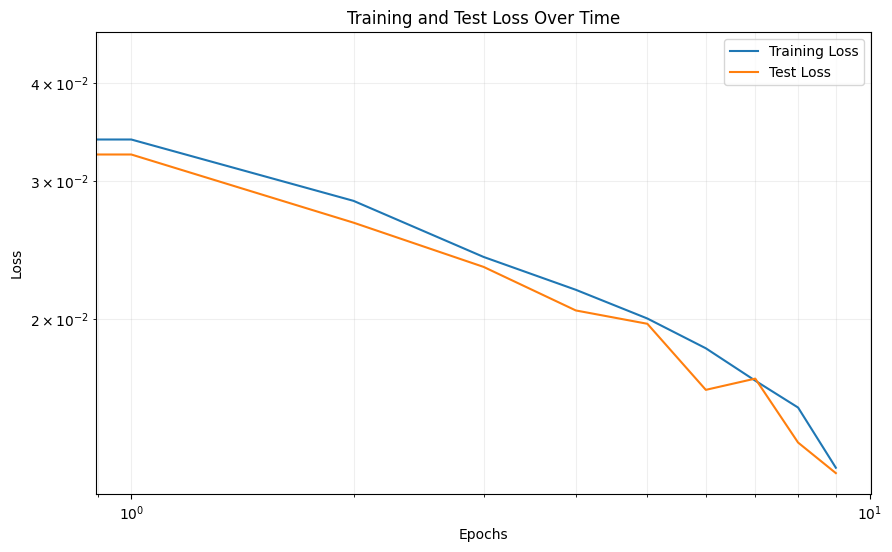

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


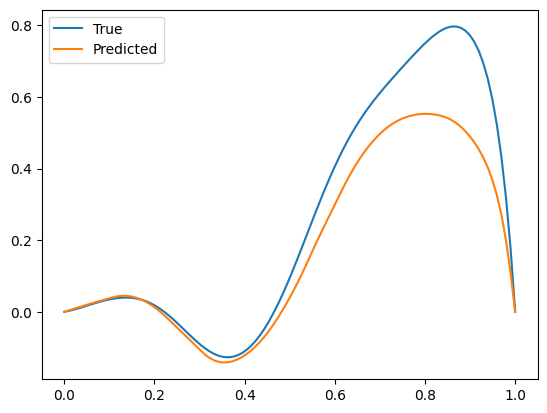

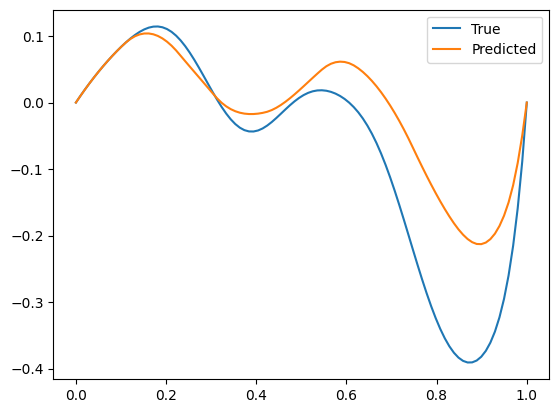

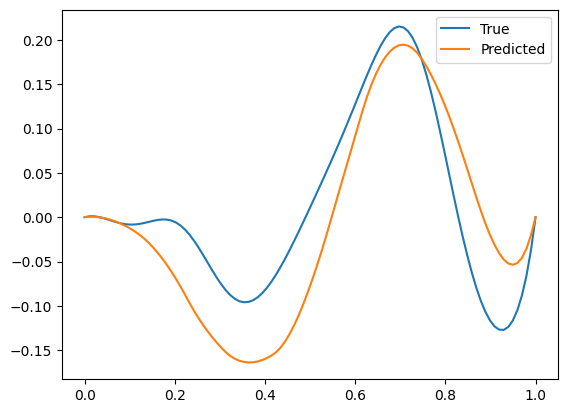

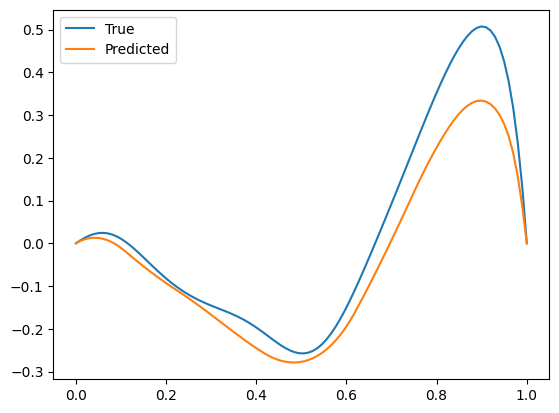

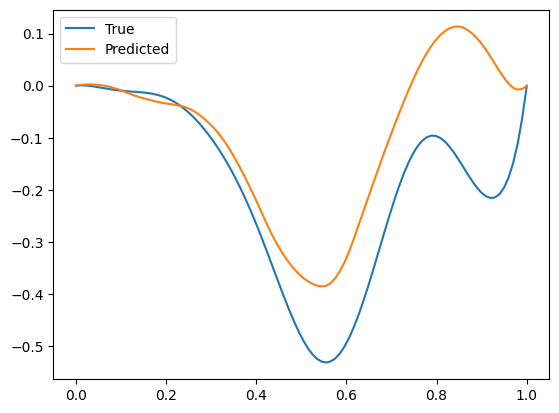

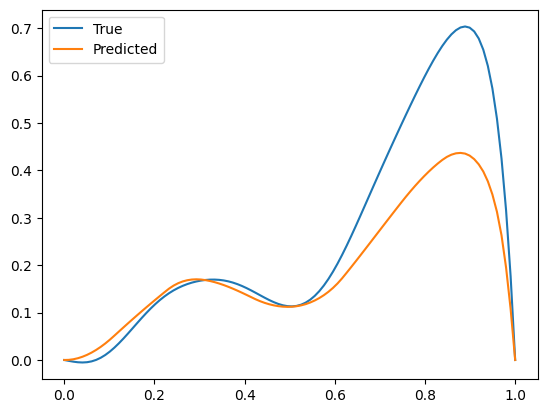

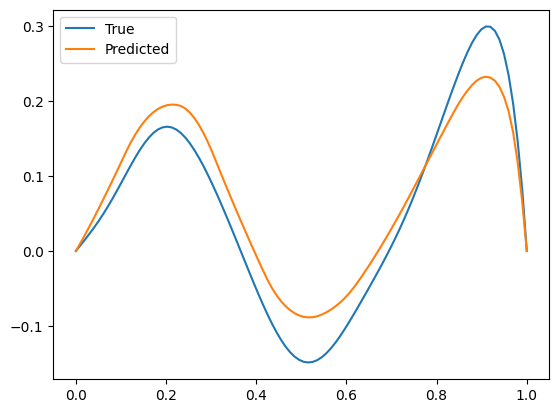

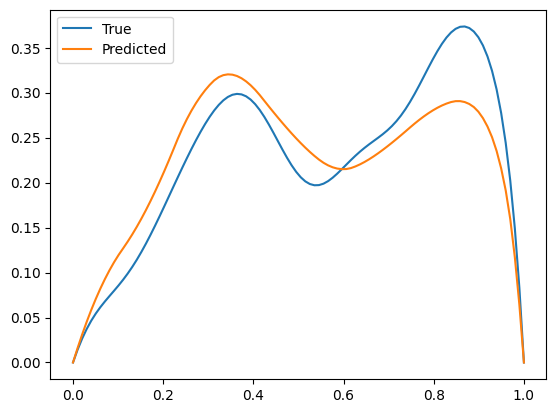

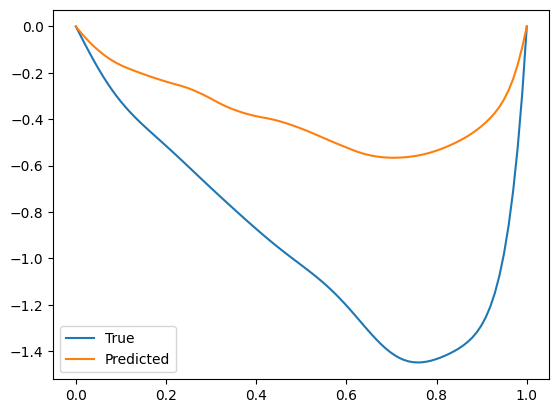

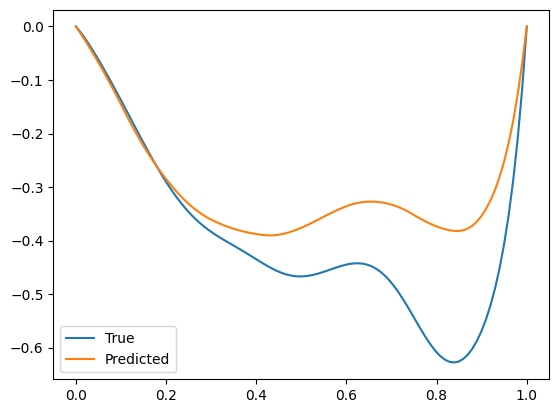

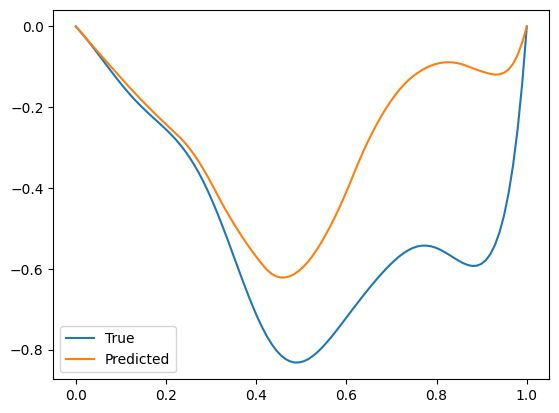

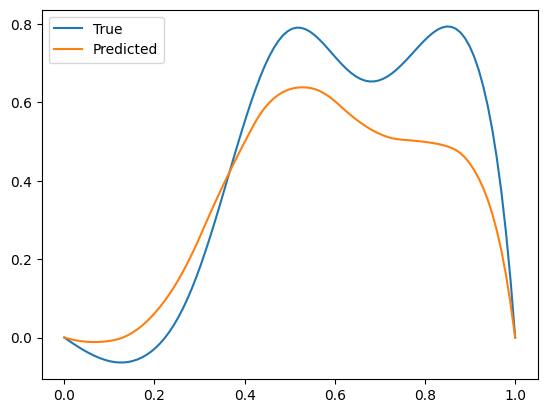

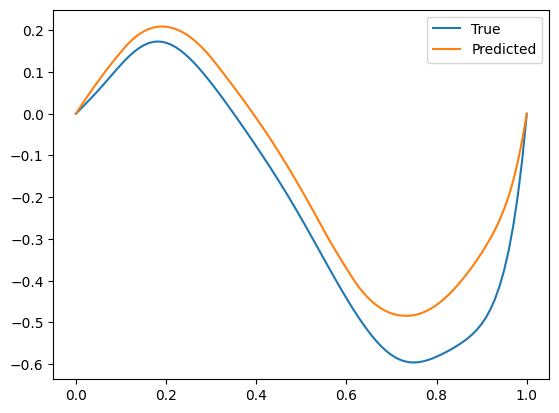

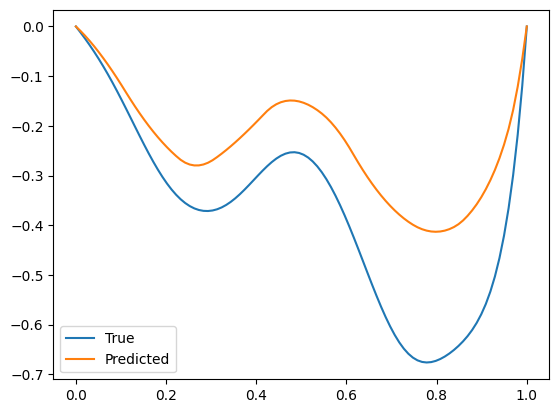

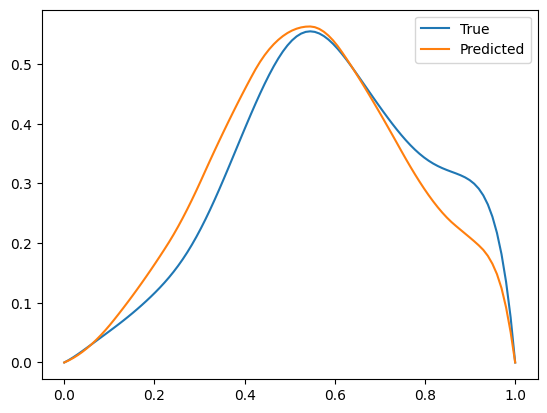

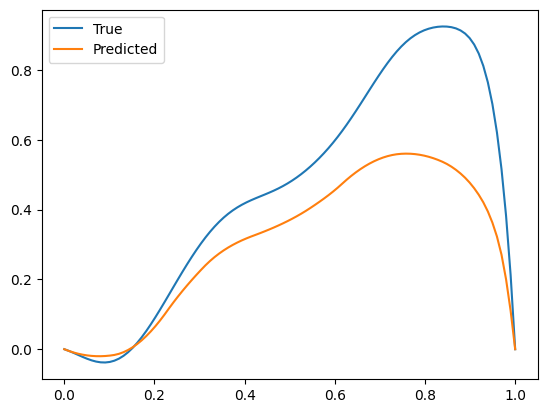

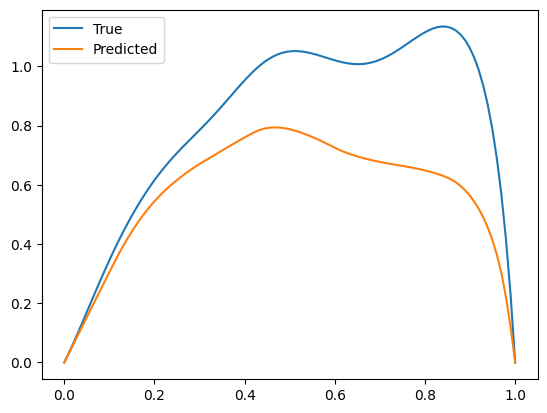

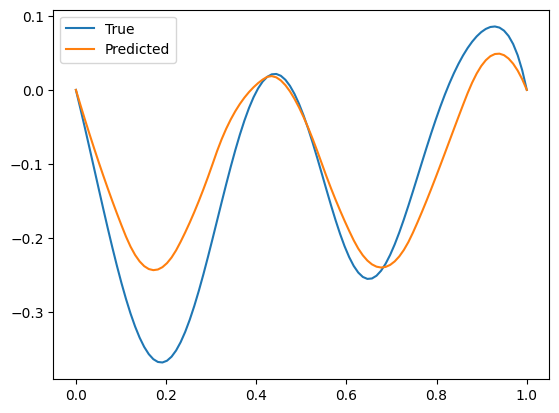

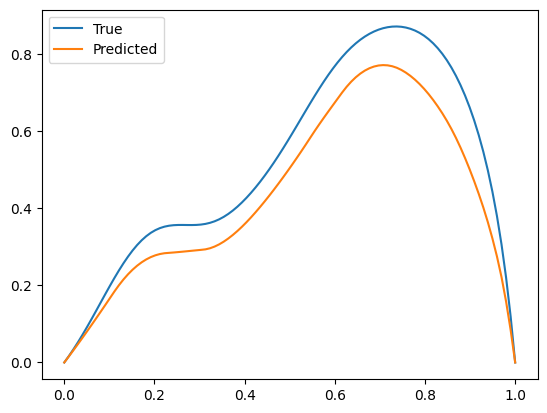

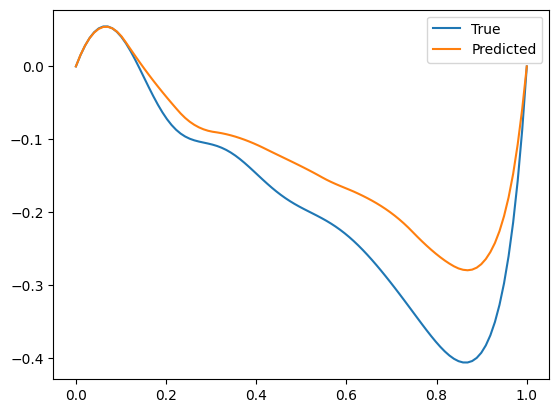

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 14:20:42,906 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 14:20:42,908 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.013298
2025-08-06 14:20:42,911 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.012317
Training progress:  10%|█         | 1/10 [00:09<01:26,  9.67s/it]2025-08-06 14:20:53,835 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 14:20:53,837 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.011374
2025-08-06 14:20:53,838 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.047195
Training progress:  20%|██        | 2/10 [00:20<01:23, 10.41s/it]2025-08-06 14:21:04,360 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 14:21:04,362 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.017502
2025-08-06 14:21:04,363 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.012455
Training progress:  30%|███       | 3/10 [00:31<01:13, 10.46s/i

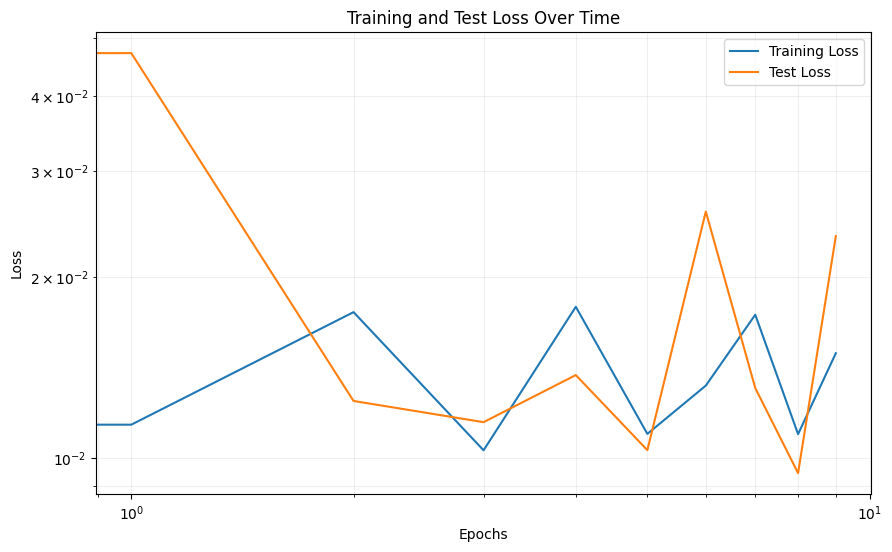

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


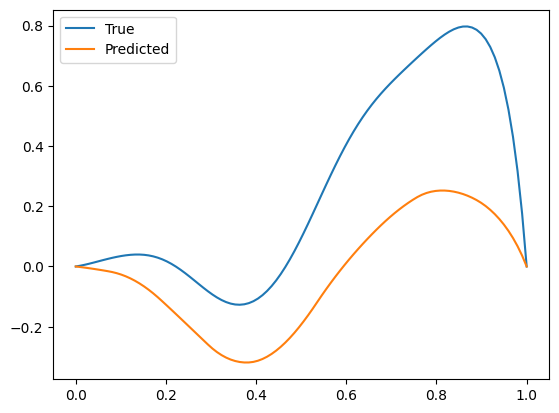

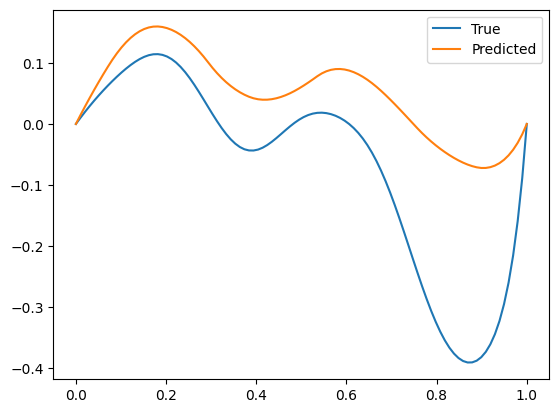

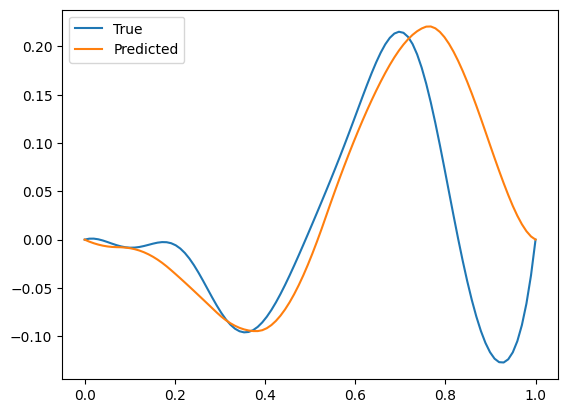

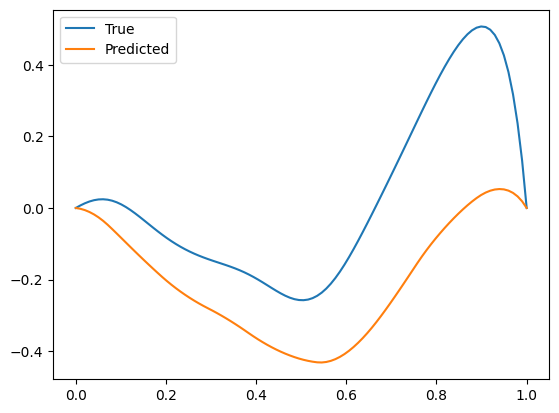

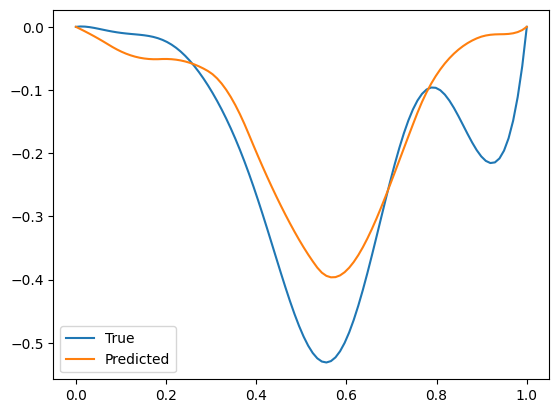

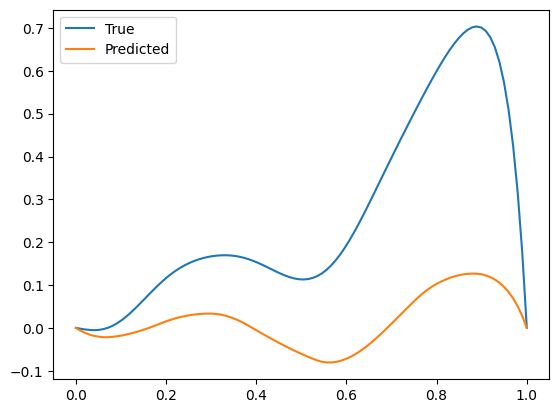

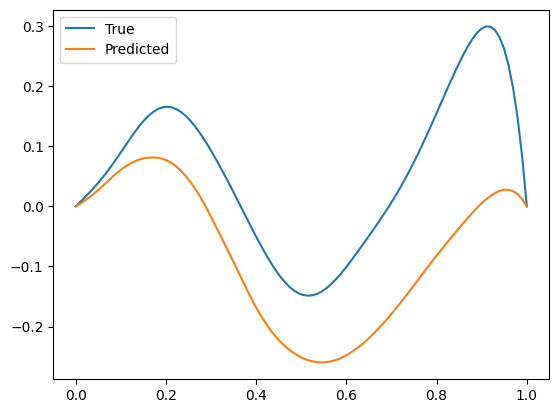

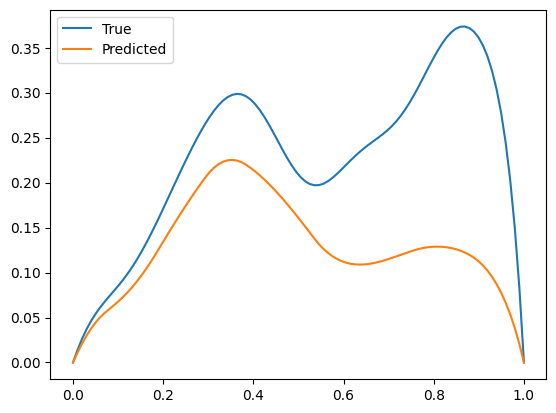

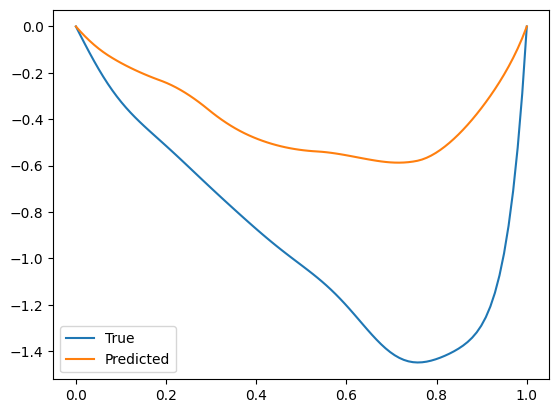

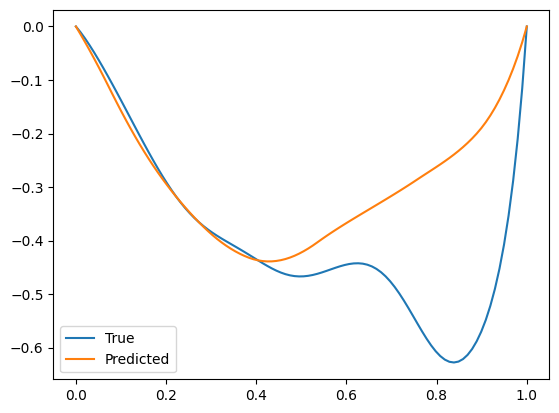

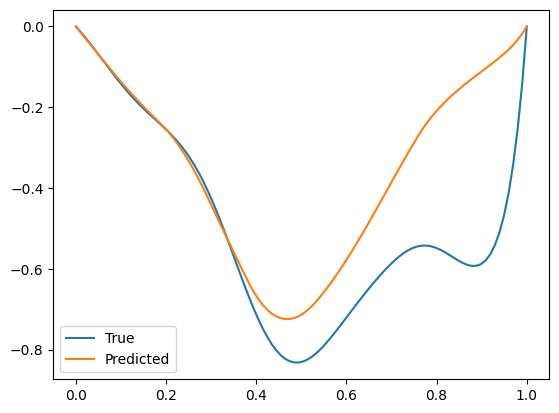

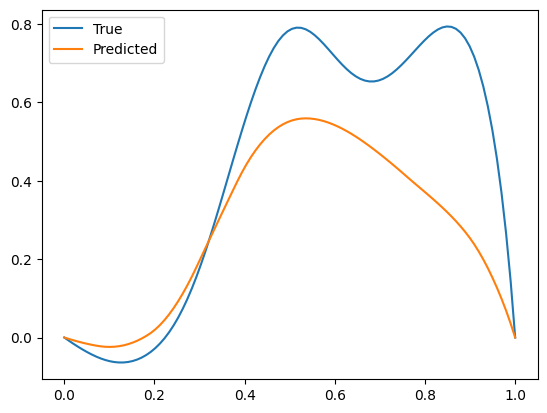

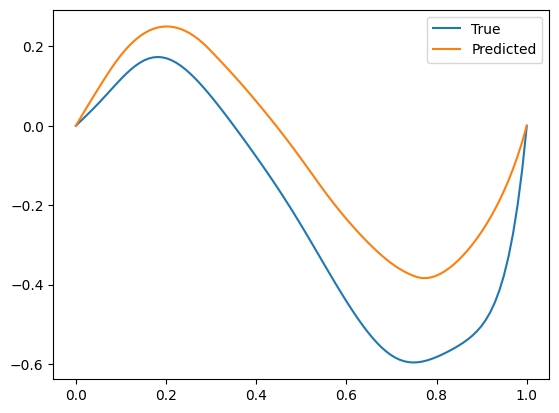

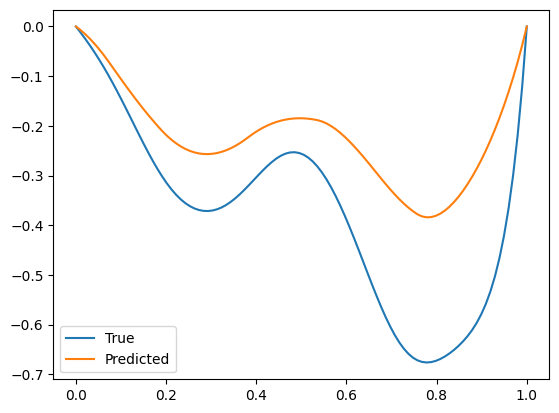

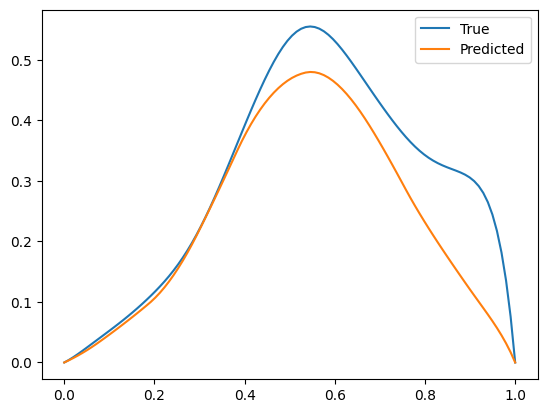

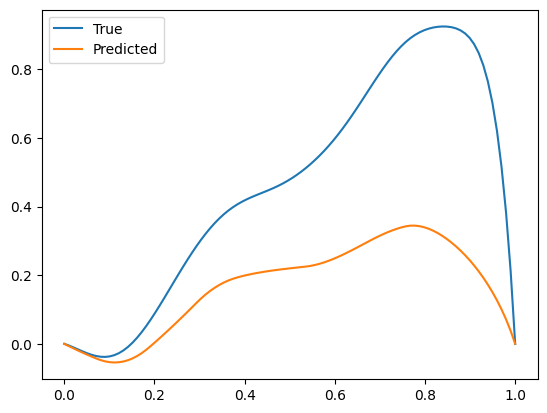

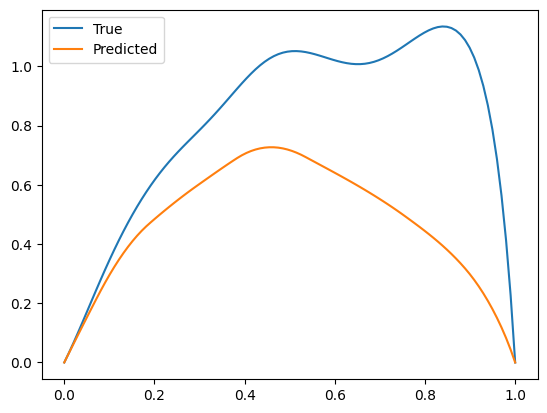

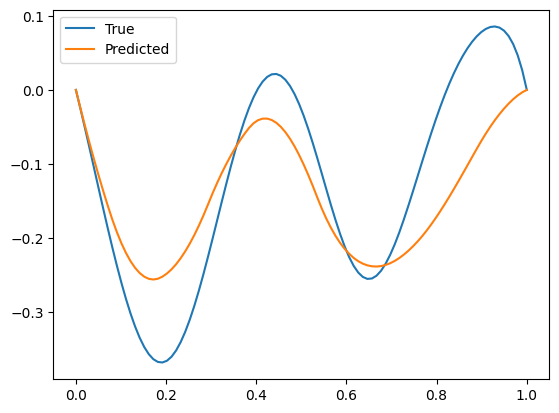

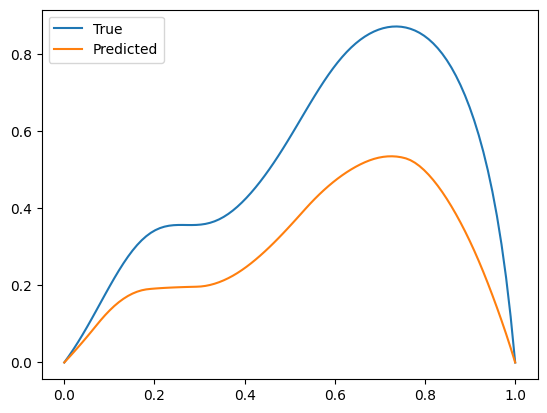

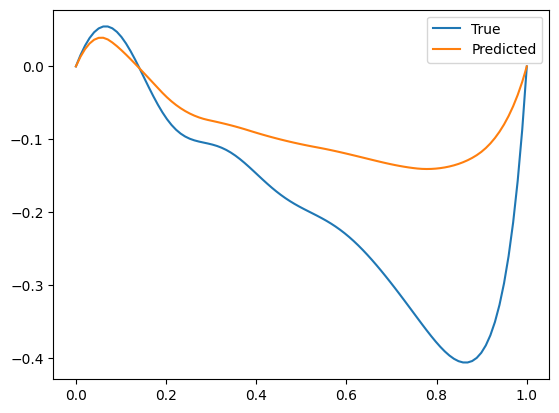

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 14:22:14,356 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 14:22:14,358 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.015482
2025-08-06 14:22:14,360 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.011762
Training progress:  10%|█         | 1/10 [00:09<01:23,  9.27s/it]2025-08-06 14:22:24,458 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 14:22:24,460 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.009849
2025-08-06 14:22:24,461 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.008625
Training progress:  20%|██        | 2/10 [00:19<01:18,  9.76s/it]2025-08-06 14:22:32,082 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 14:22:32,084 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.008561
2025-08-06 14:22:32,086 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.036794
Training progress:  30%|███       | 3/10 [00:26<01:01,  8.78s/i

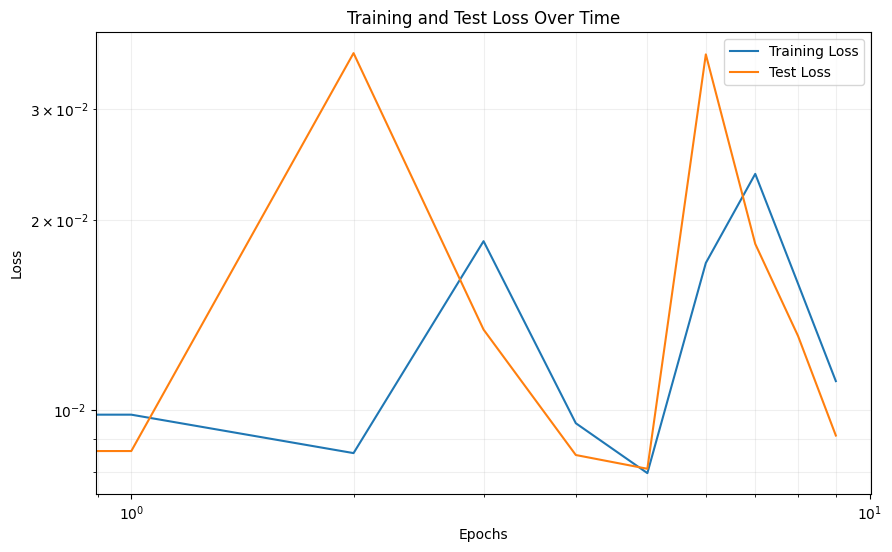

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


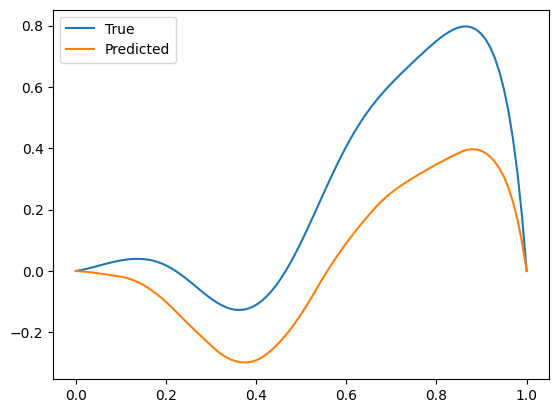

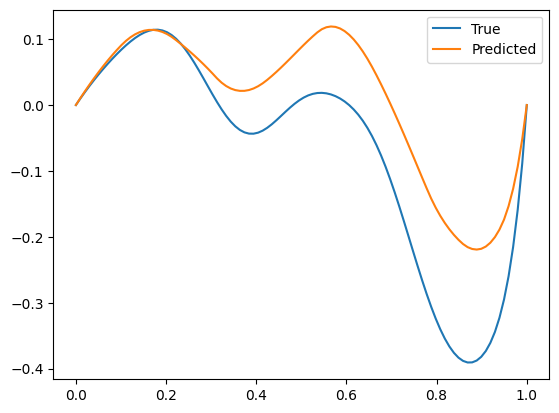

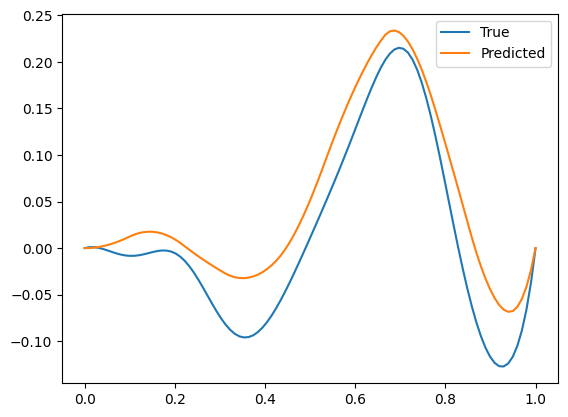

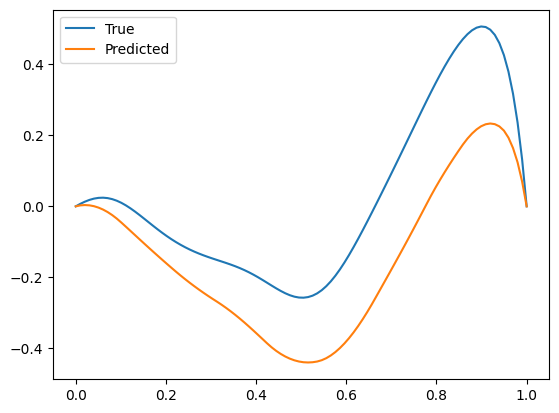

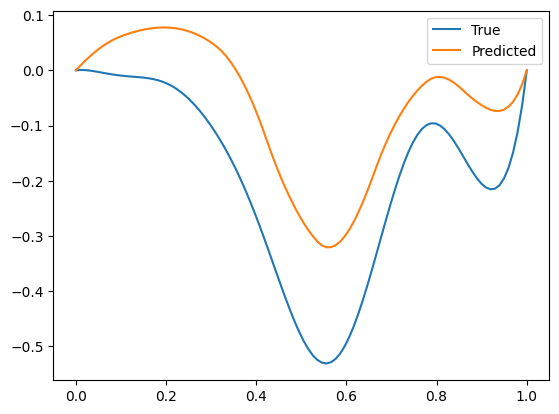

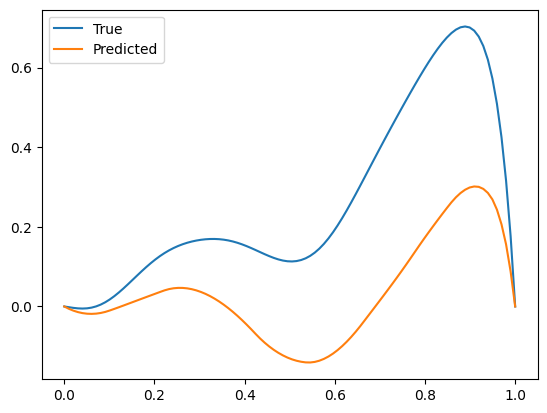

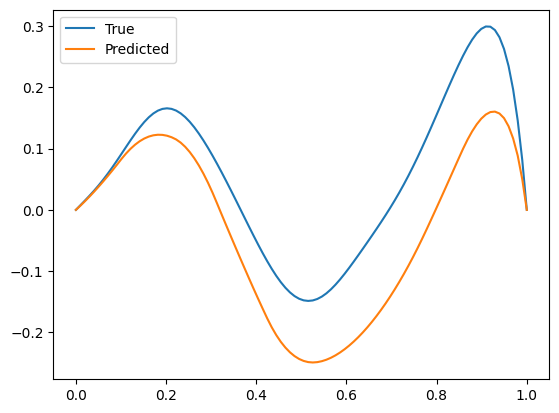

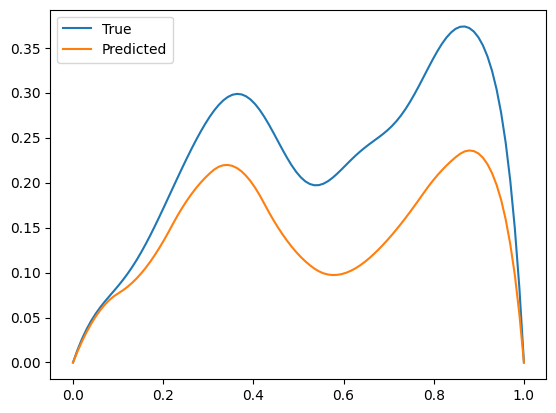

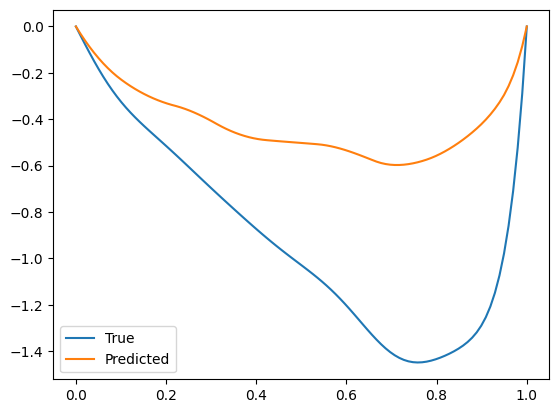

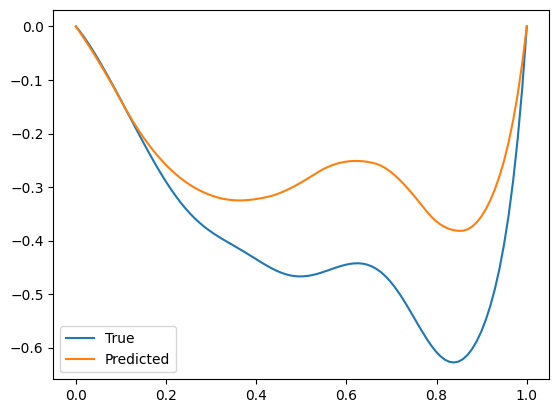

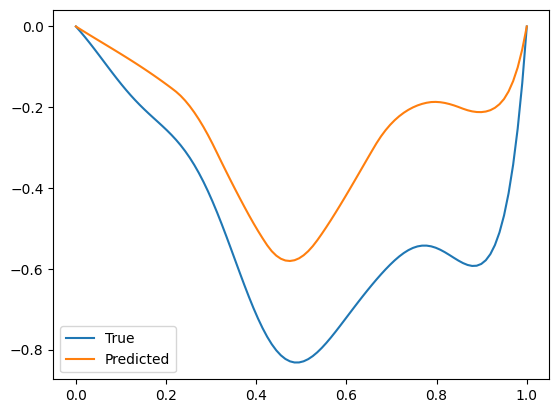

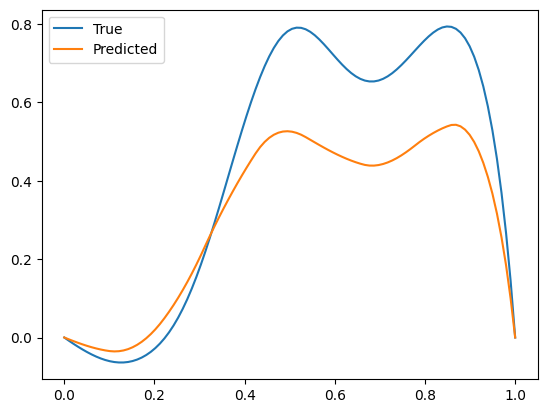

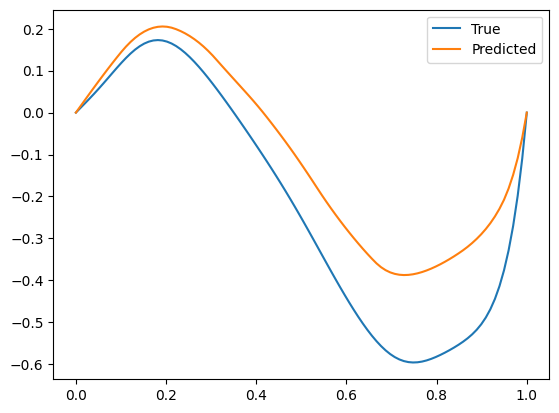

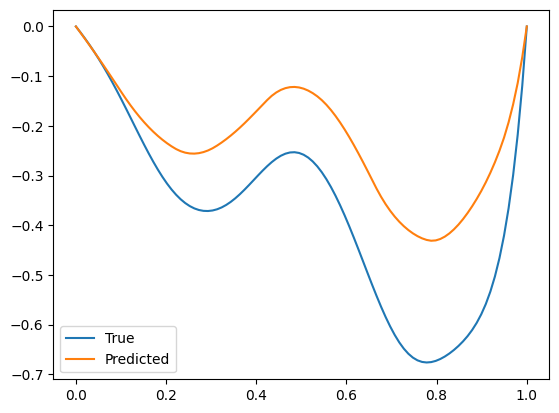

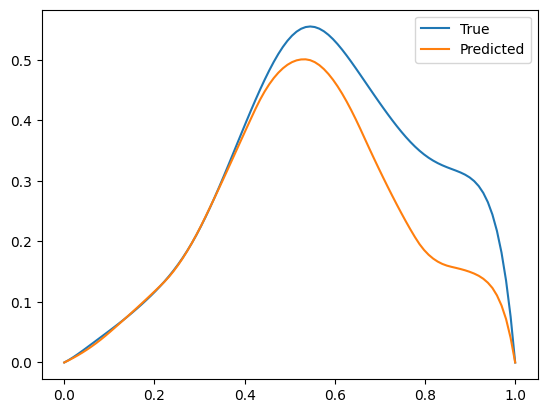

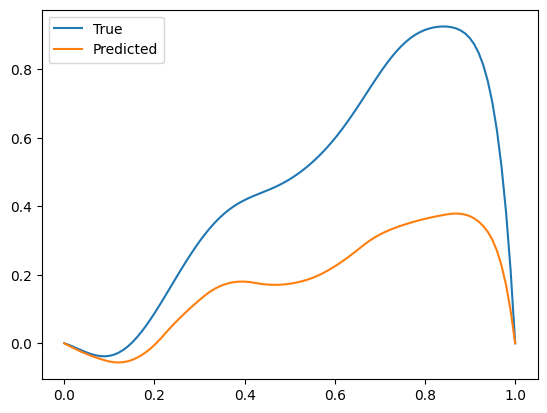

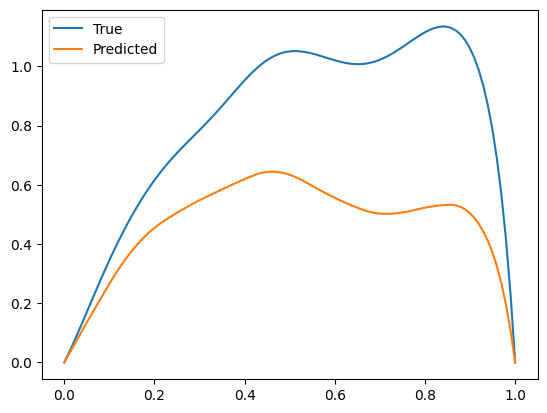

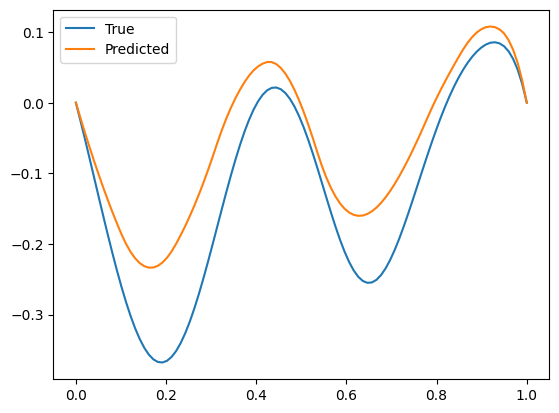

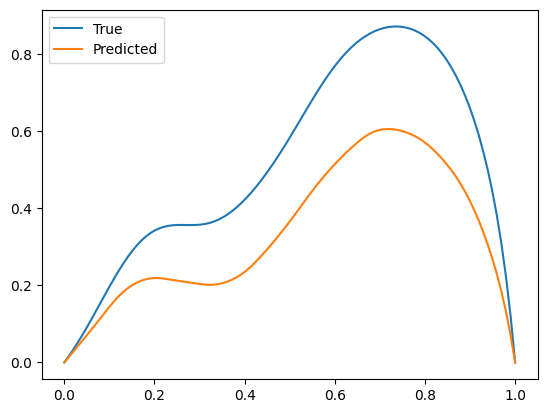

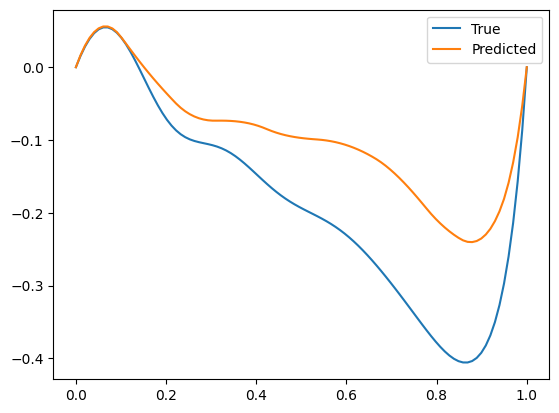

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


2025-08-06 14:23:36.147482: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 14:23:43,797 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 14:23:43,799 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.010323
2025-08-06 14:23:43,800 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.014042
Training progress:  10%|█         | 1/10 [00:07<01:08,  7.62s/it]2025-08-06 14:23:51,344 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 14:23:51,345 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.016477
2025-08-06 14:23:51,346 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.011240
Training progress:  20%|██        | 2/10 [00:15<01:00,  7.58s/it]2025-08-06 14:23:58,807 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 14:23:58,809 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.00

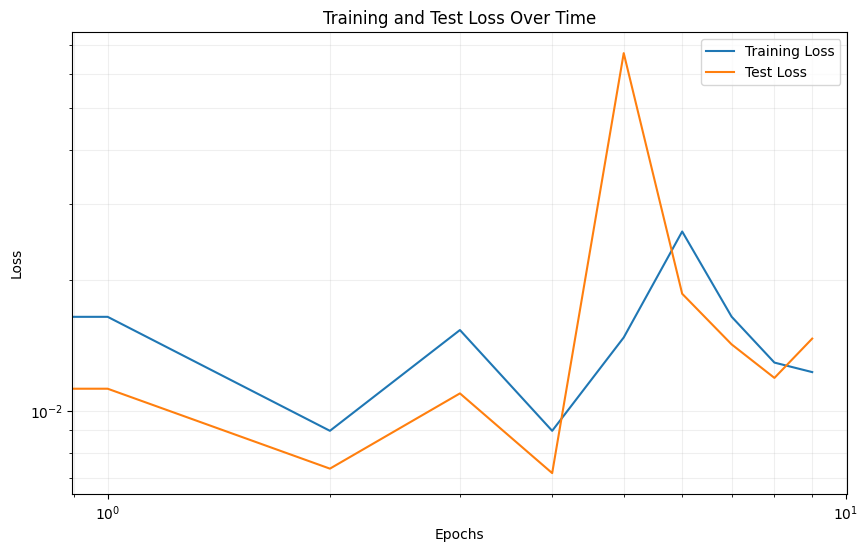

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


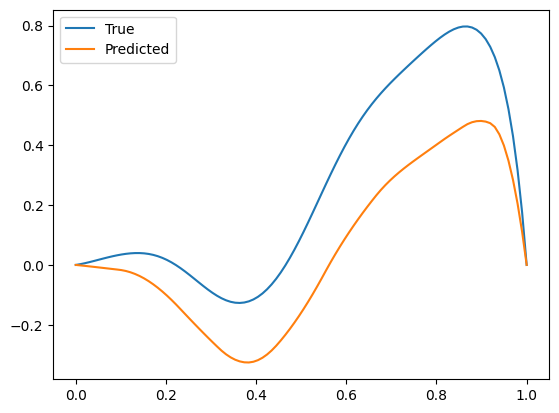

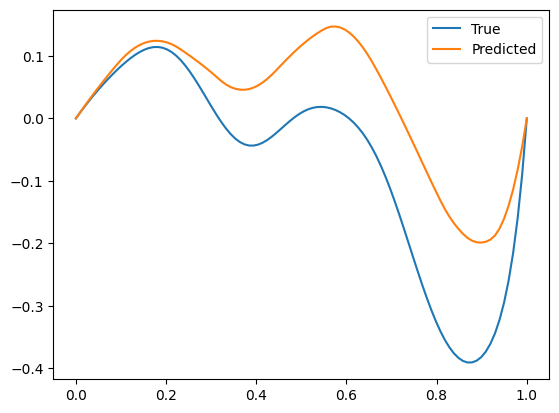

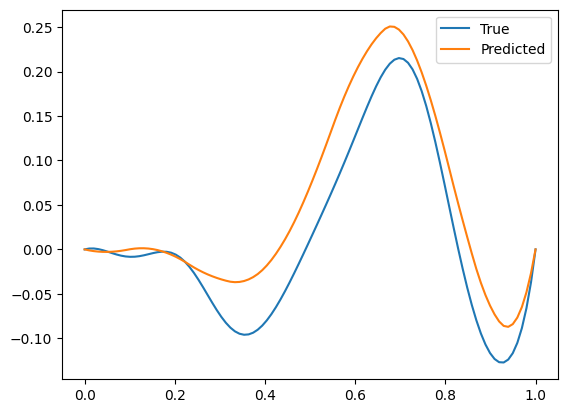

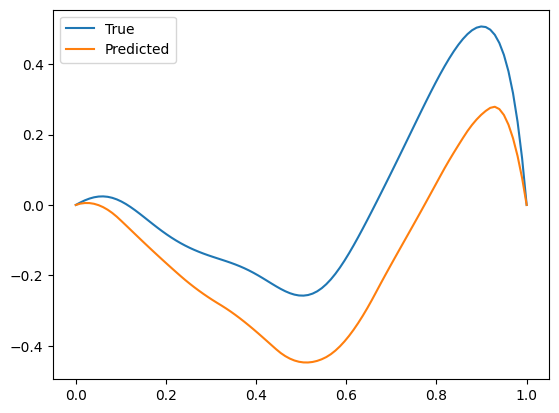

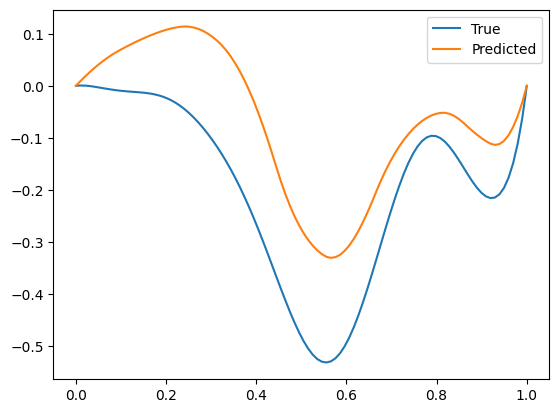

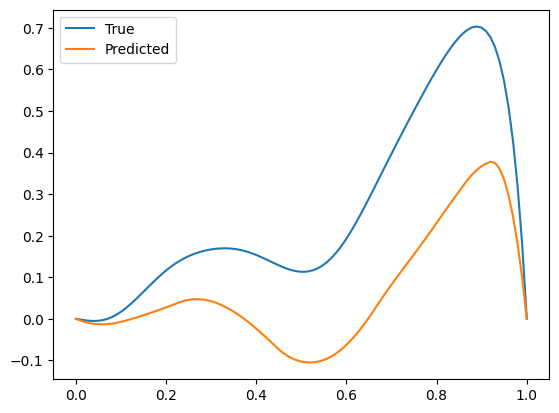

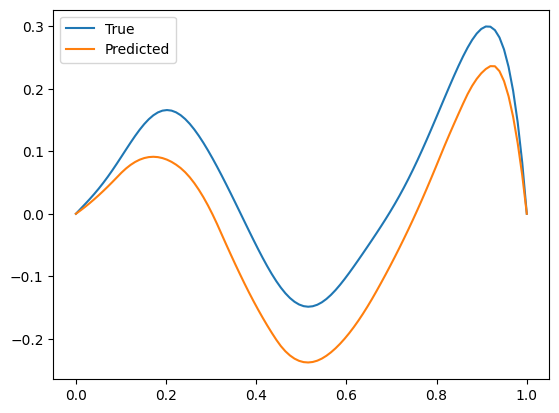

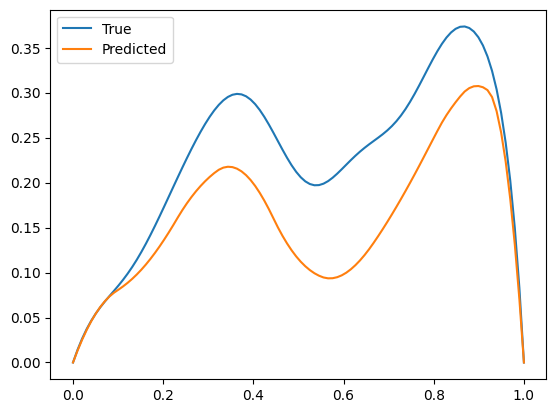

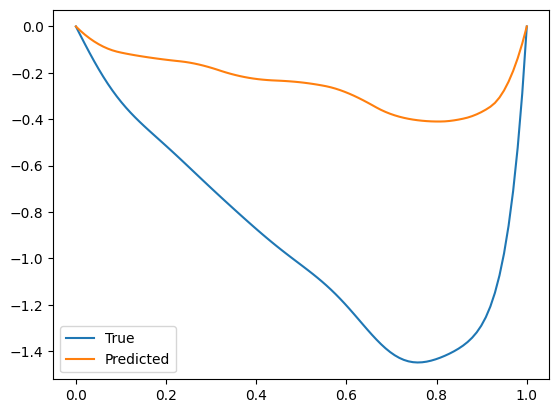

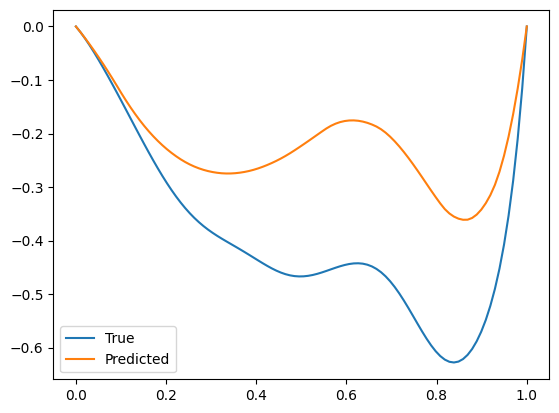

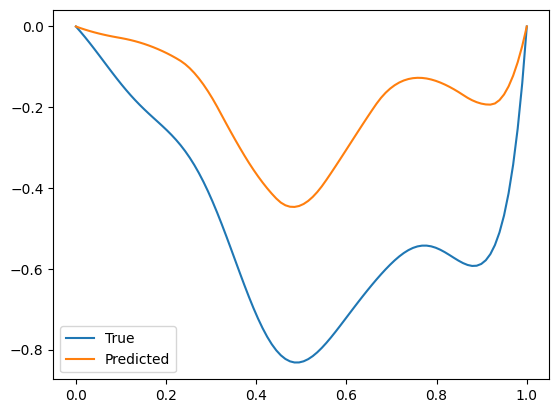

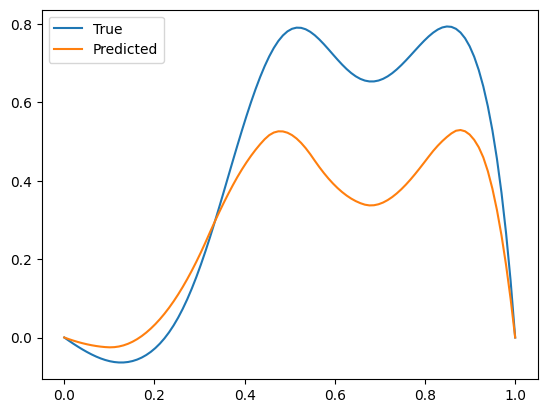

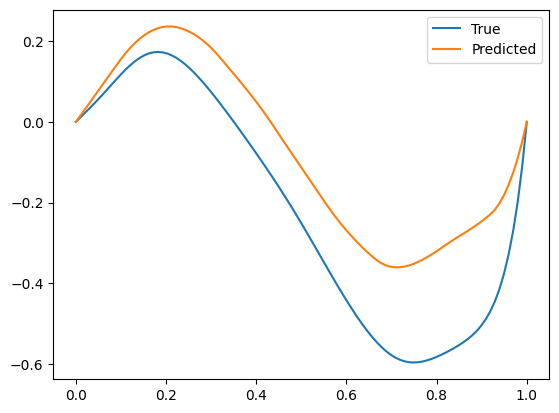

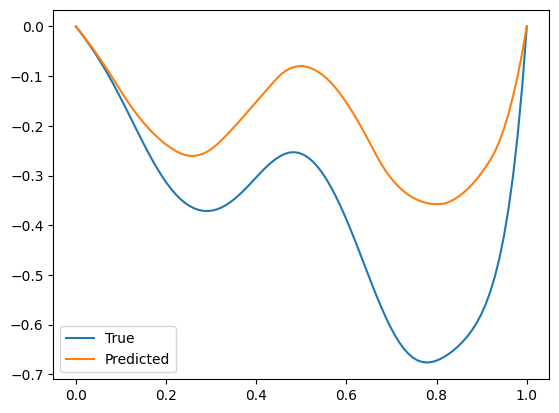

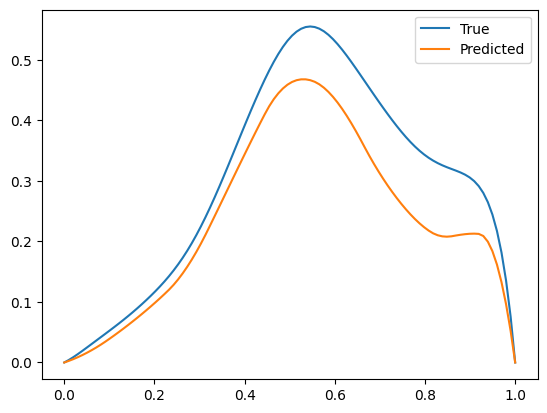

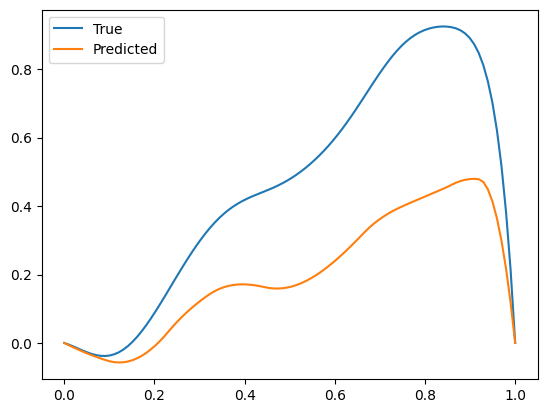

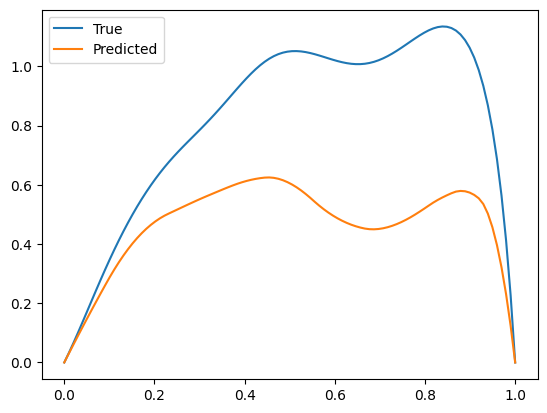

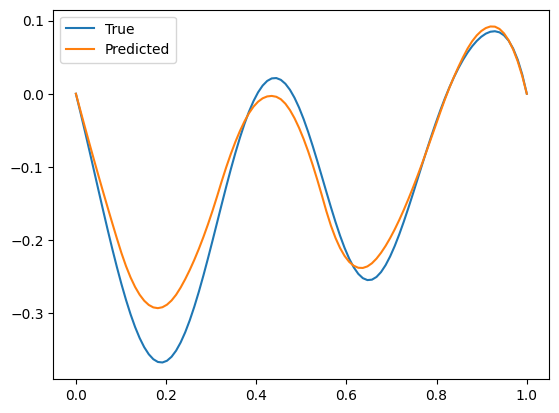

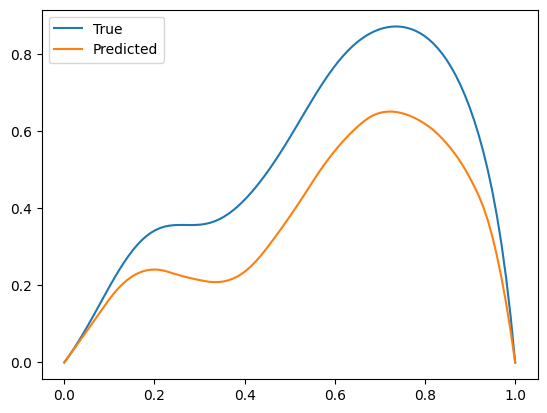

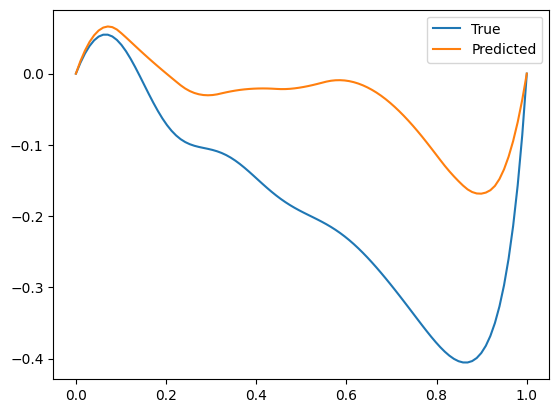

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 14:25:00,141 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 14:25:00,142 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.013425
2025-08-06 14:25:00,143 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.011199
Training progress:  10%|█         | 1/10 [00:07<01:04,  7.14s/it]2025-08-06 14:25:07,475 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 14:25:07,476 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.010515
2025-08-06 14:25:07,478 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.009777
Training progress:  20%|██        | 2/10 [00:14<00:58,  7.26s/it]2025-08-06 14:25:14,328 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 14:25:14,329 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.009558
2025-08-06 14:25:14,330 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.009900
Training progress:  30%|███       | 3/10 [00:21<00:49,  7.07s/i

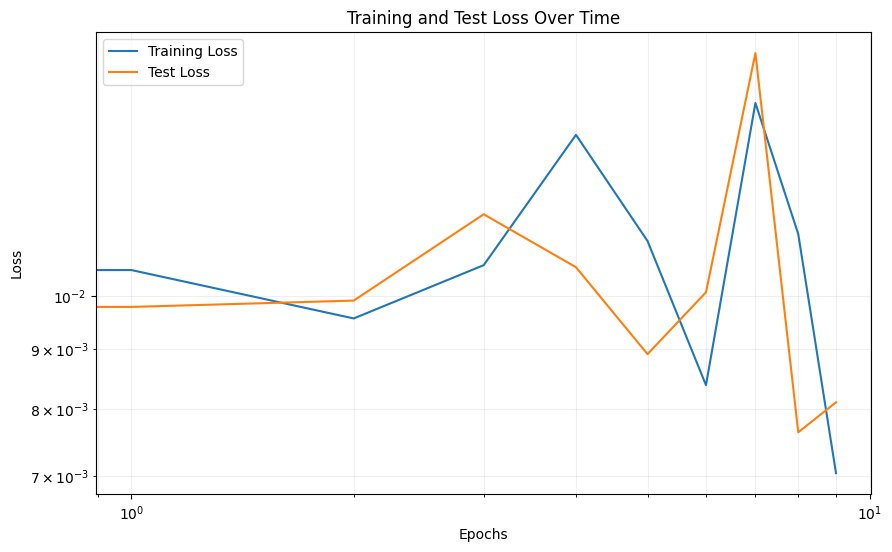

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


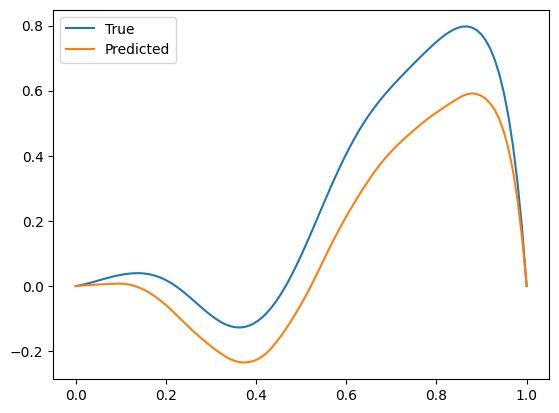

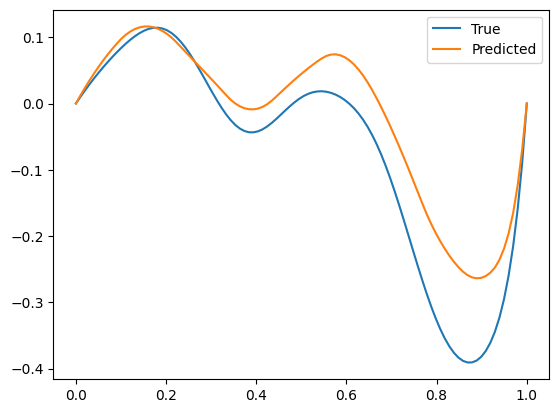

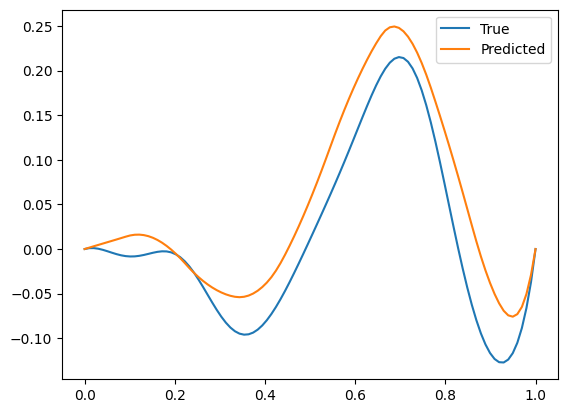

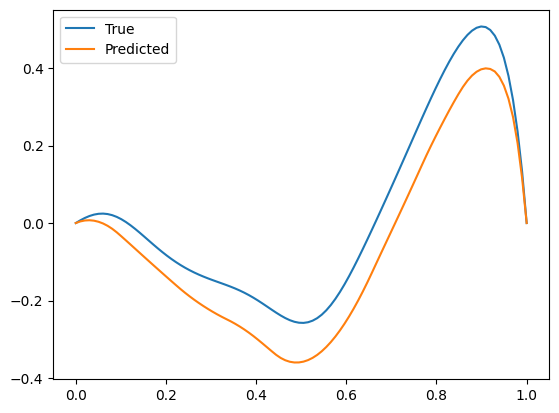

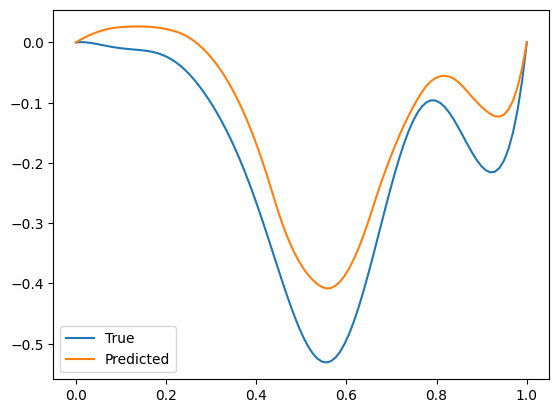

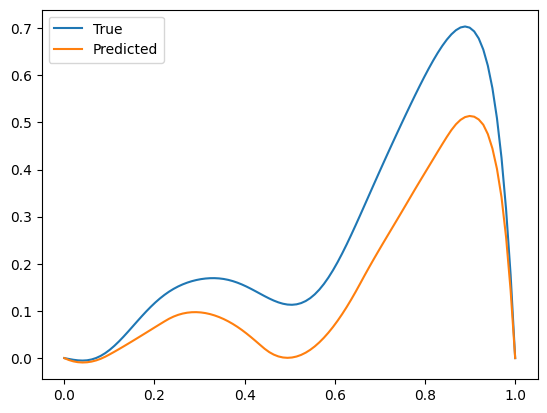

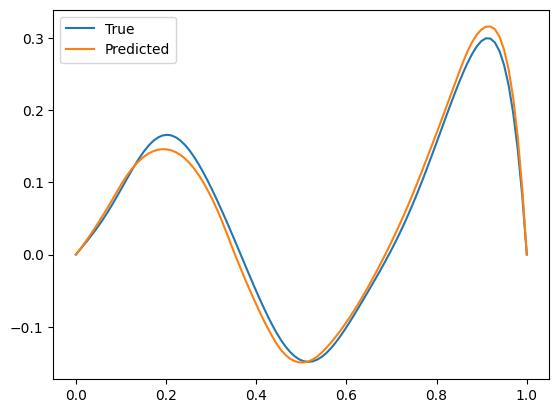

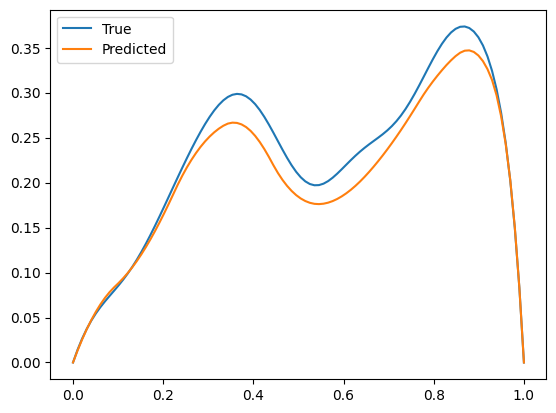

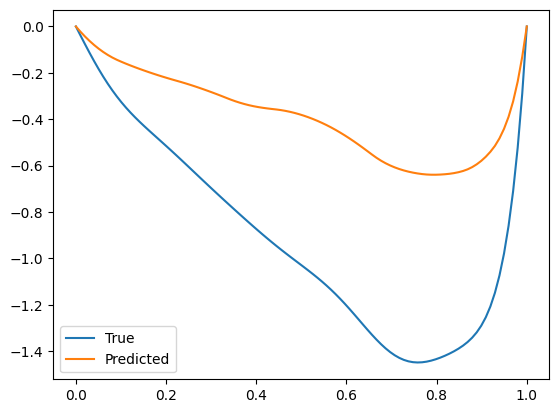

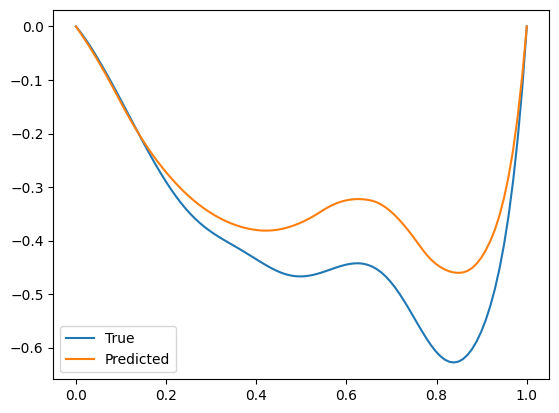

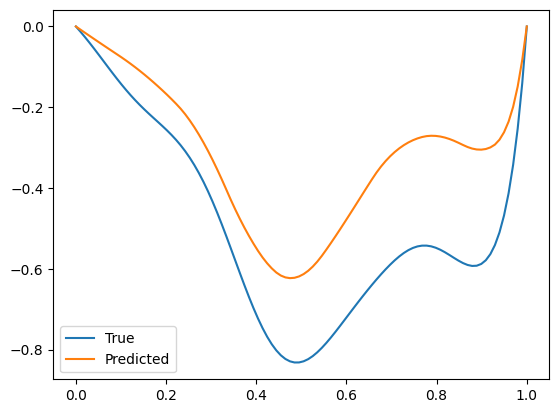

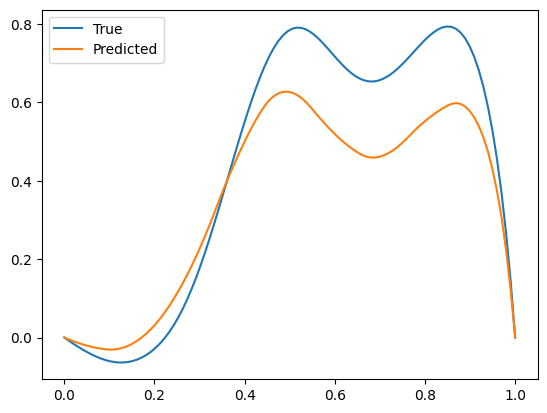

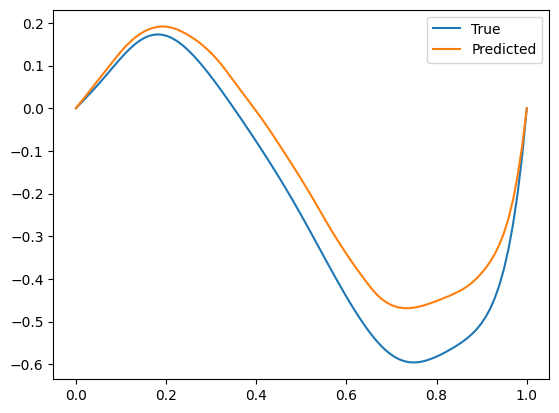

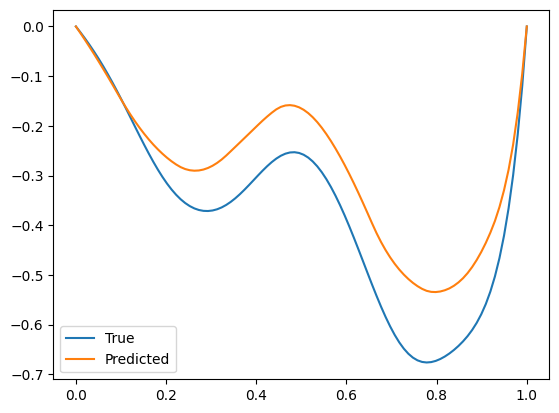

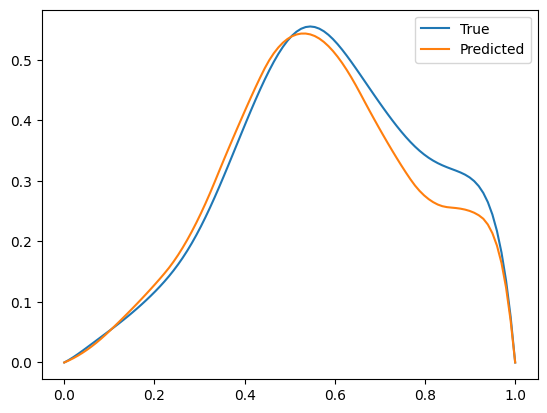

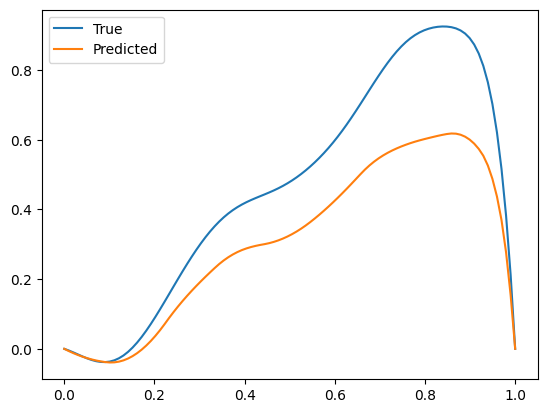

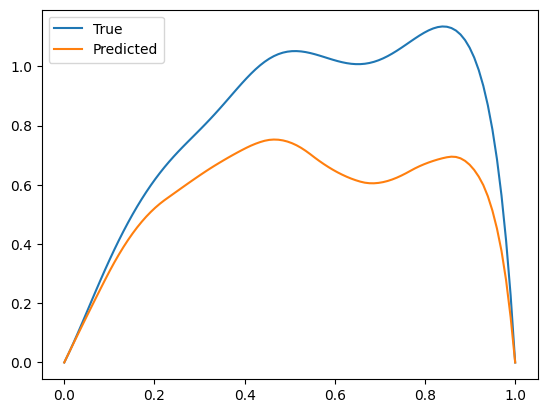

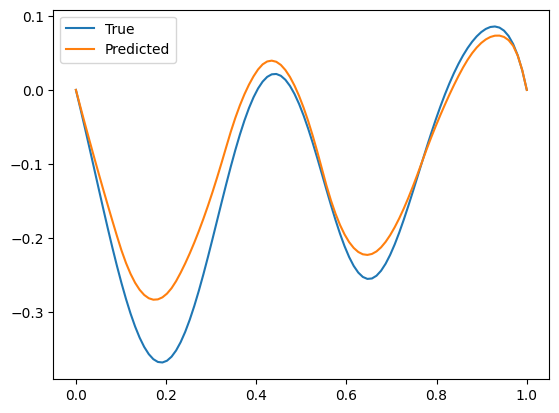

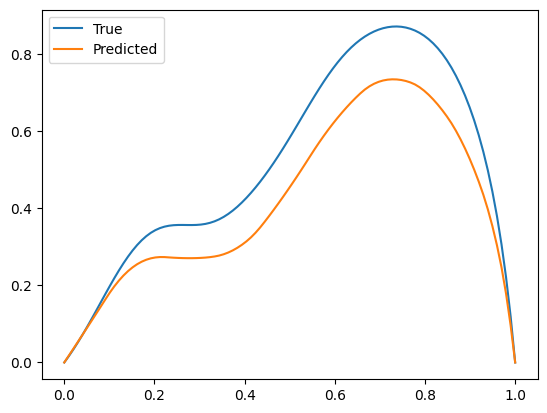

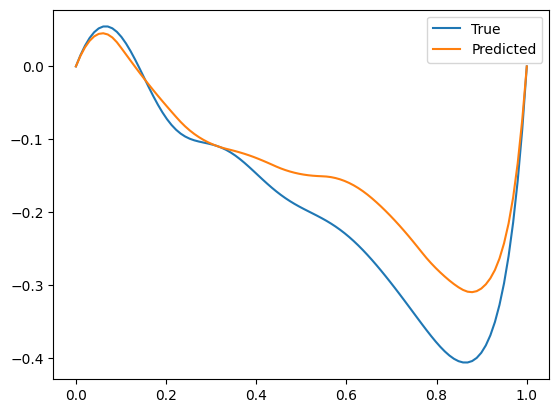

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 14:26:23,624 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 14:26:23,626 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.015694
2025-08-06 14:26:23,627 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.015981
Training progress:  10%|█         | 1/10 [00:07<01:10,  7.86s/it]2025-08-06 14:26:31,121 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 14:26:31,122 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.010824
2025-08-06 14:26:31,123 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.007183
Training progress:  20%|██        | 2/10 [00:15<01:01,  7.65s/it]2025-08-06 14:26:39,315 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 14:26:39,317 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.006324
2025-08-06 14:26:39,318 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.006034
Training progress:  30%|███       | 3/10 [00:23<00:55,  7.90s/i

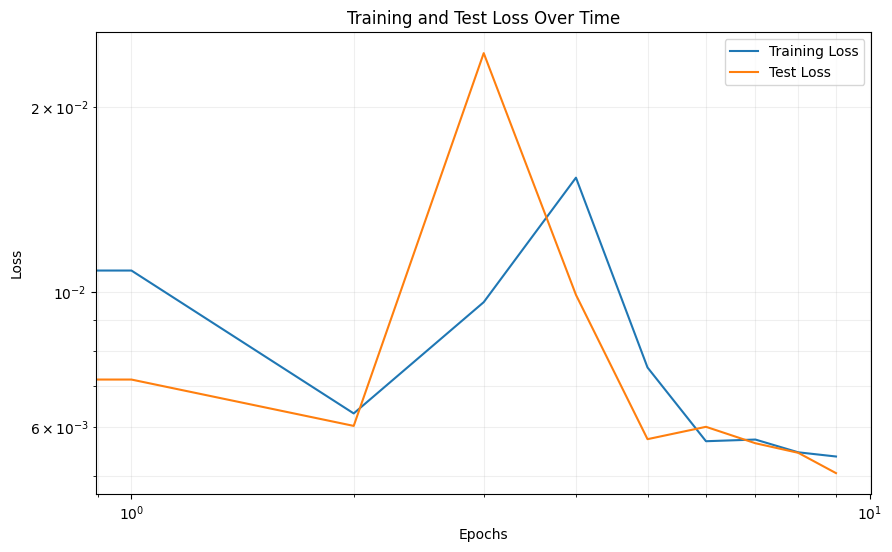

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


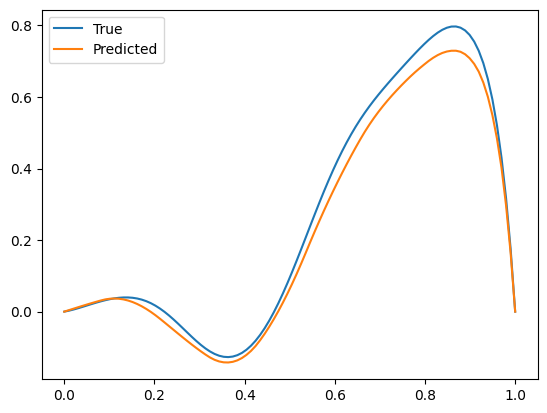

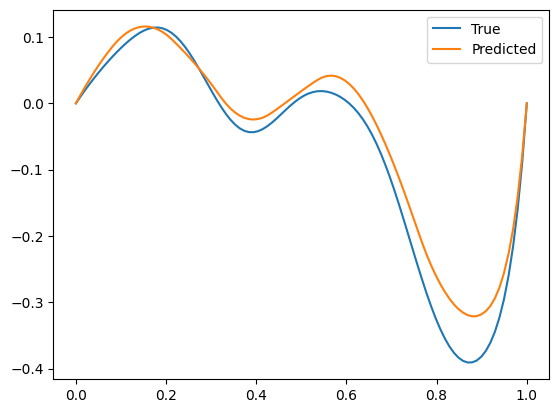

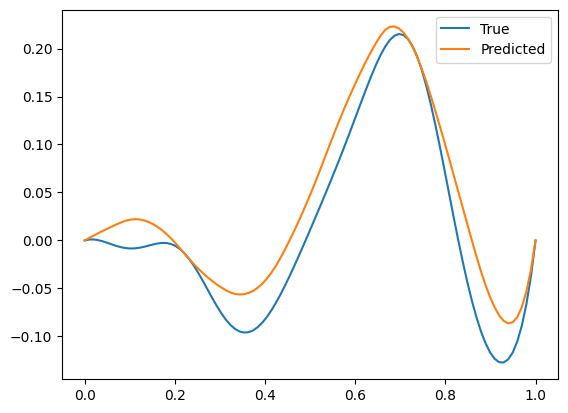

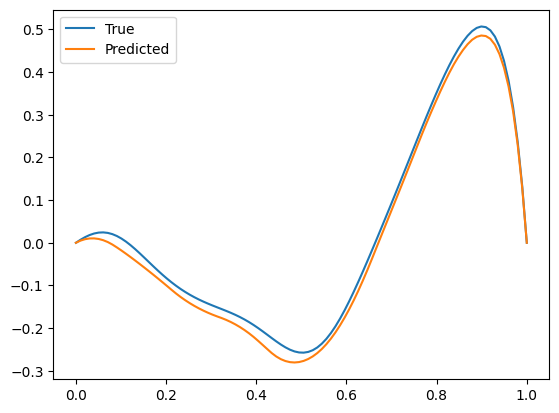

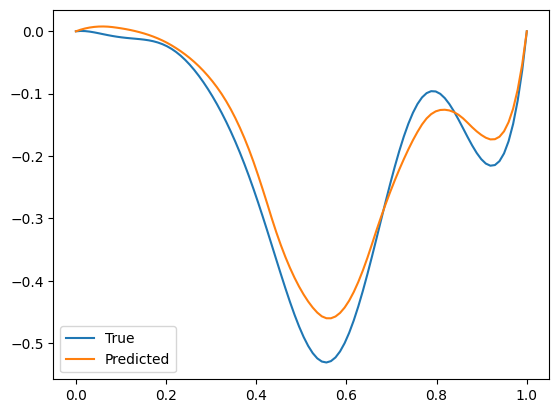

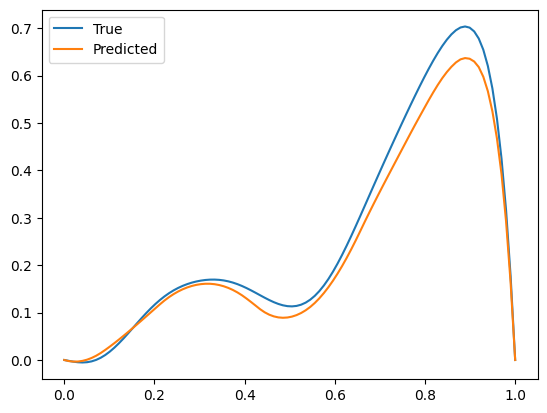

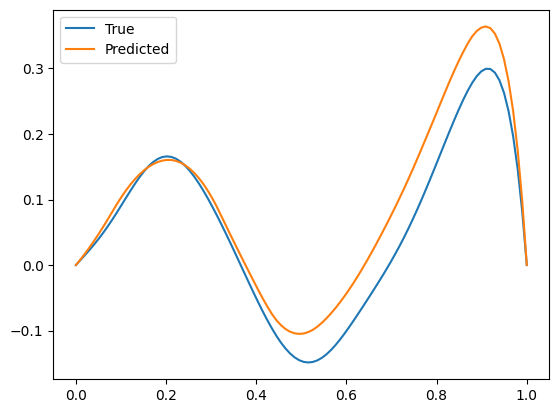

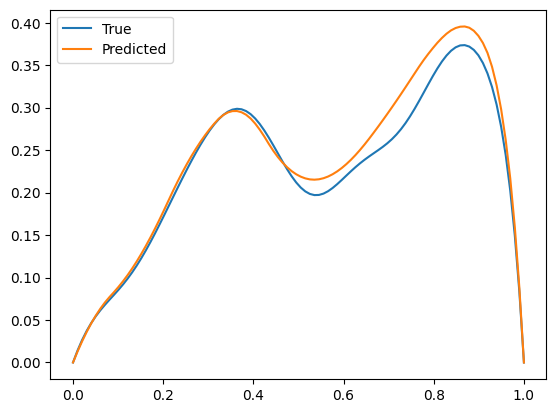

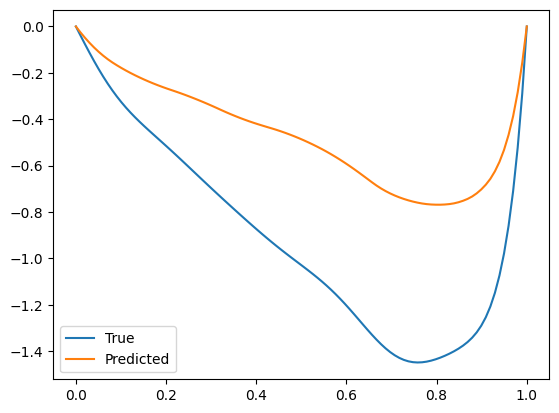

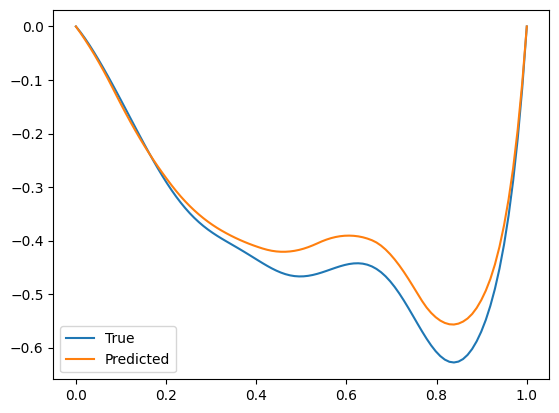

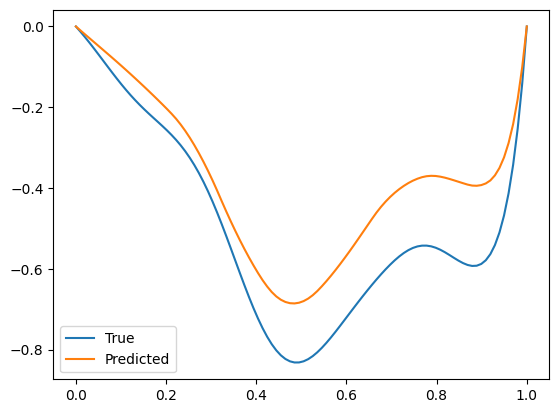

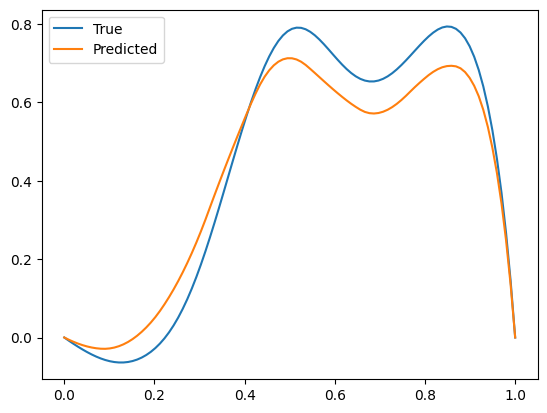

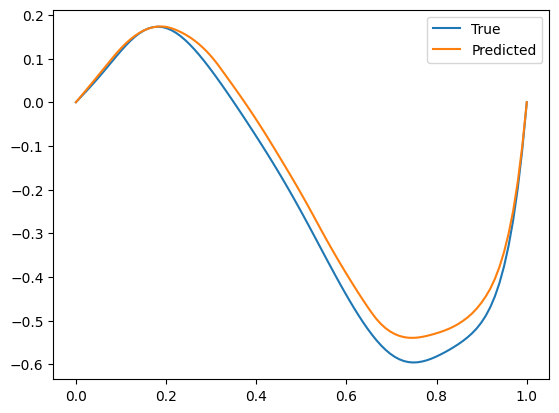

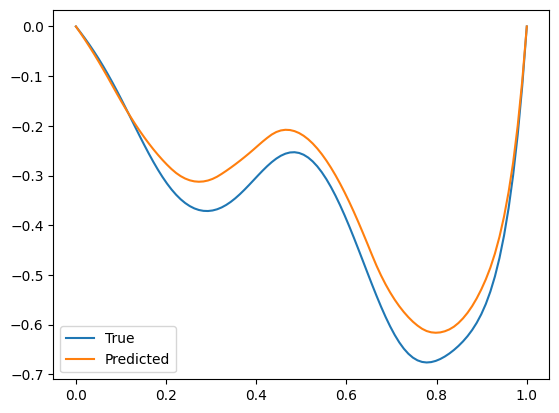

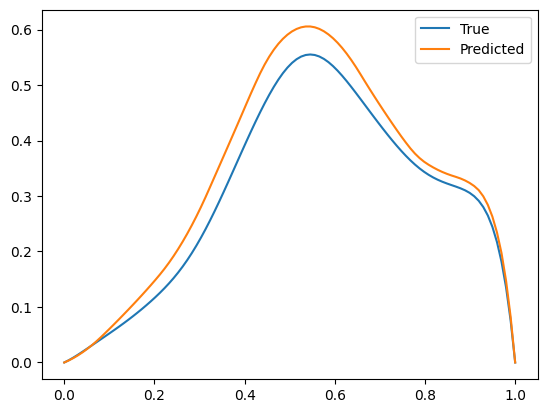

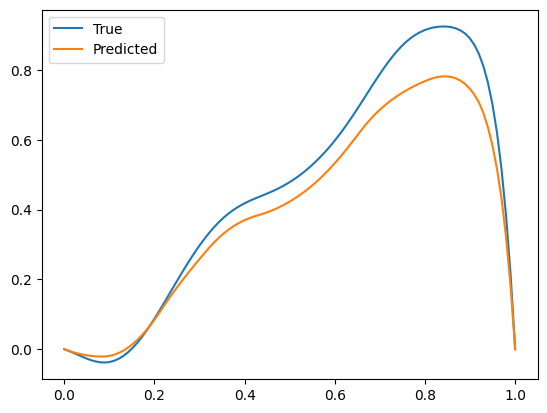

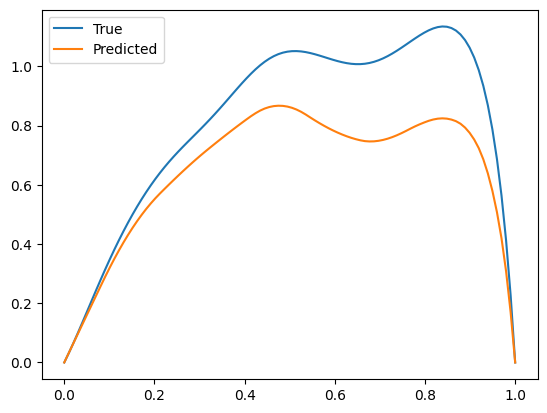

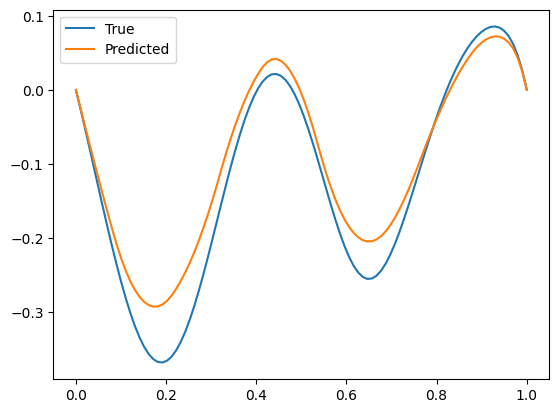

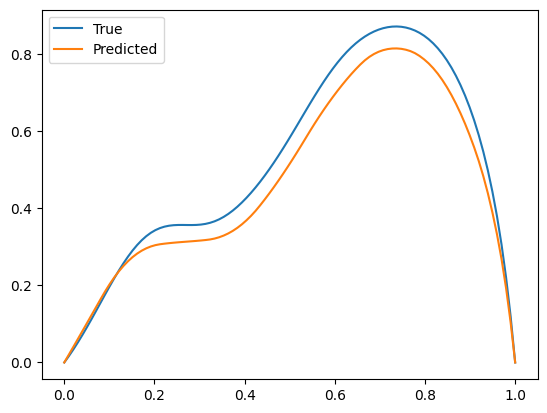

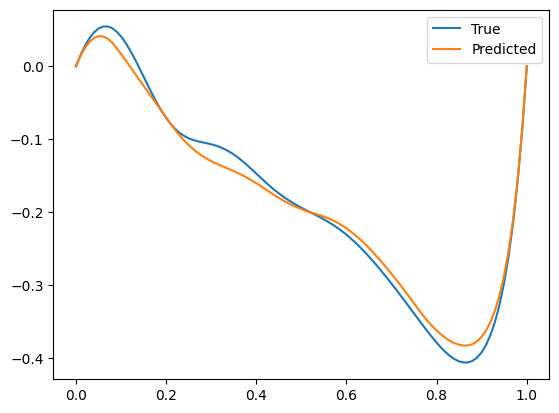

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 14:27:46.926365: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-06 14:27:47,571 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 14:27:47,573 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.004869
2025-08-06 14:27:47,574 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.004747
Training progress:  10%|█         | 1/10 [00:08<01:16,  8.50s/it]2025-08-06 14:27:56,154 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 14:27:56,155 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.004666
2025-08-06 14:27:56,156 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.004513
Training progress:  20%|██        | 2/10 [00:17<01:08,  8.55s/it]2025-08-06 14:28:04,871 - sciml.model.deeponet.deeponet - INFO - Epoch 3/10
2025-08-06 14:28:04,873 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.00

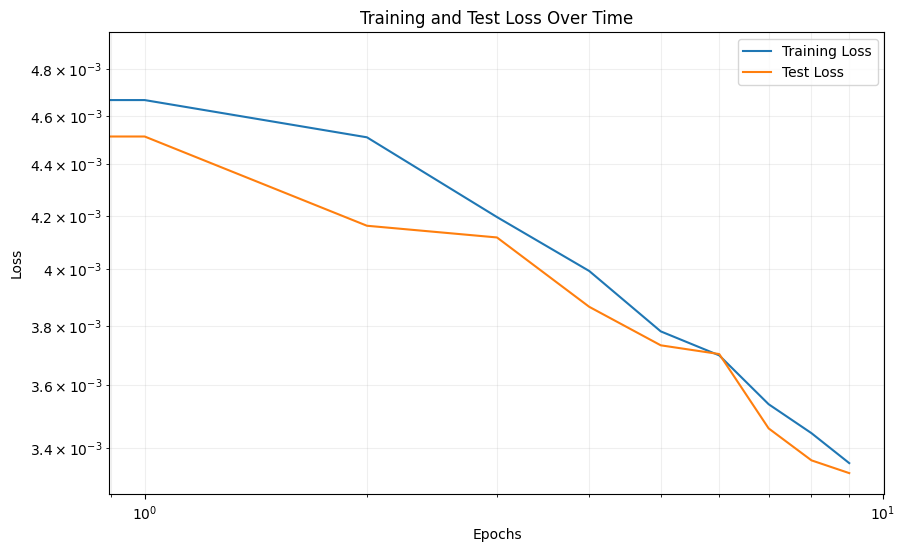

mus.shape (100, 100)
xs.shape (100, 100, 1)
sol.shape (100, 100)


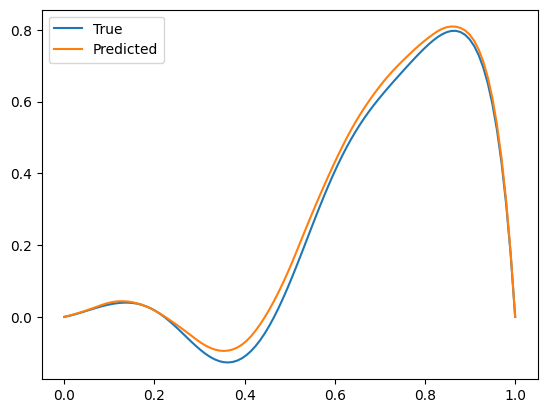

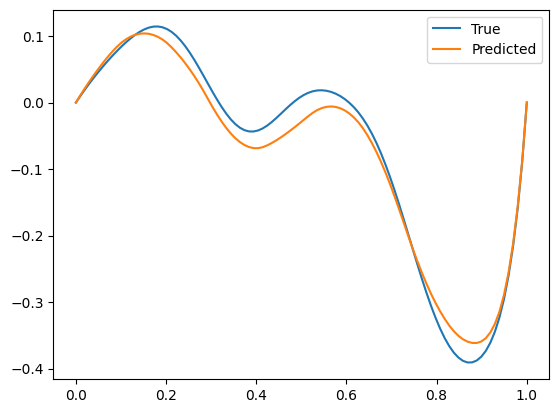

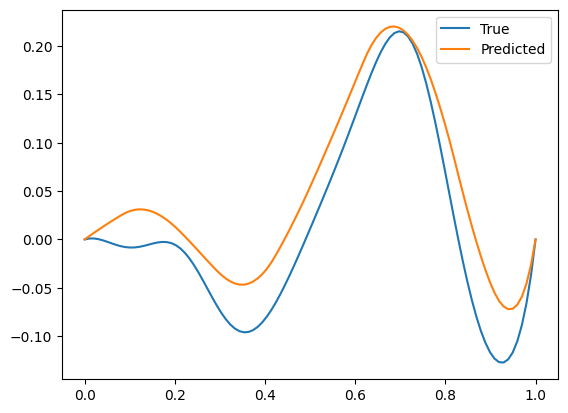

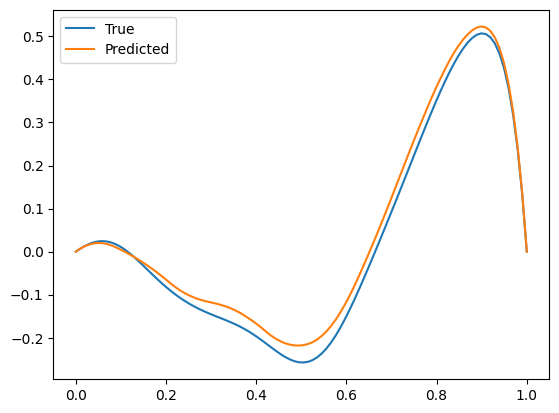

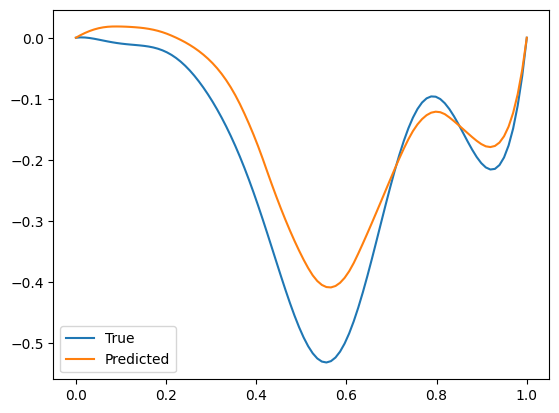

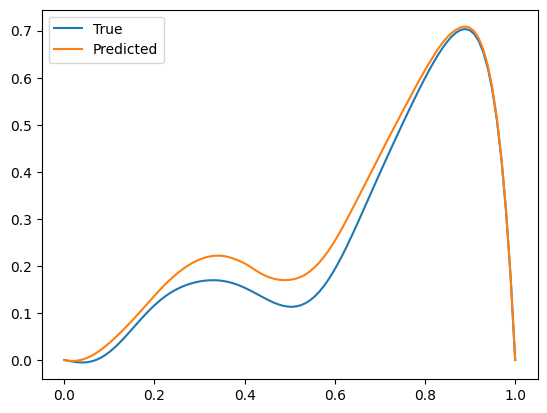

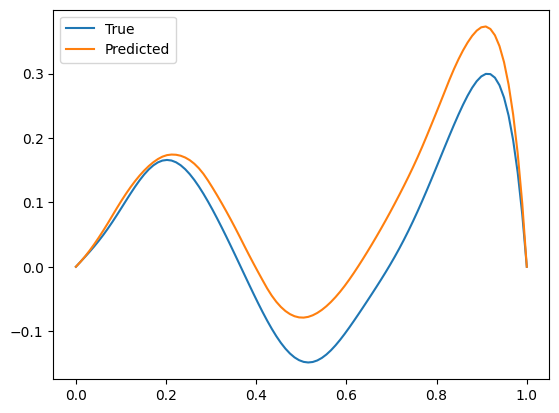

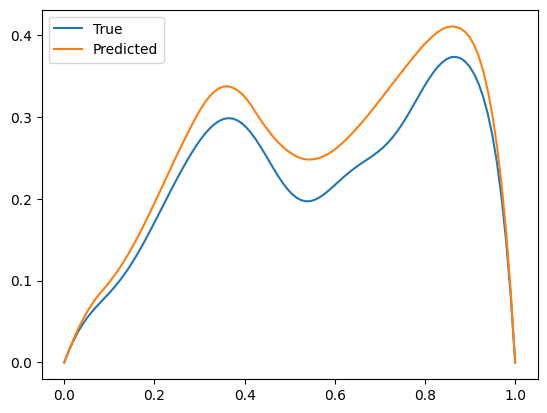

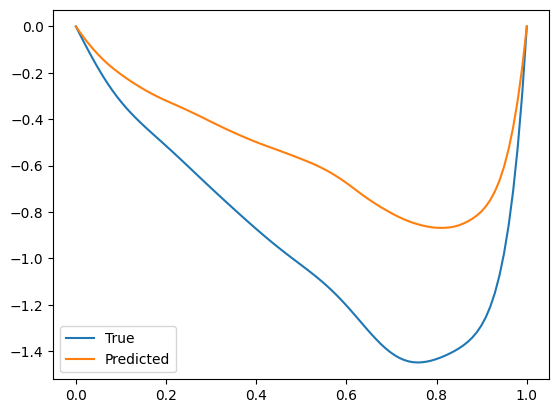

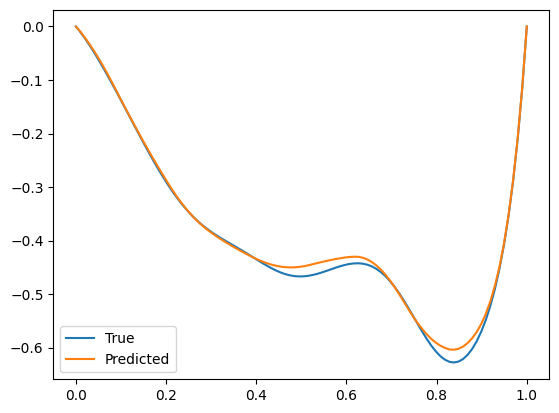

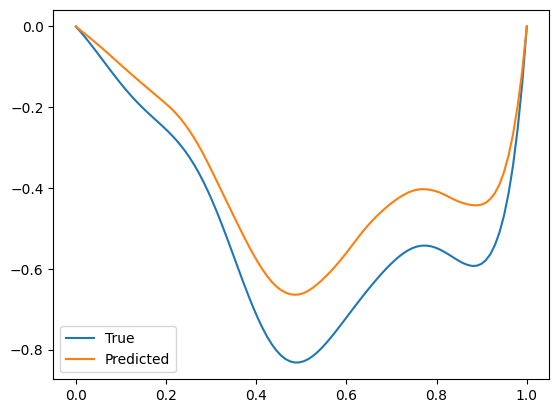

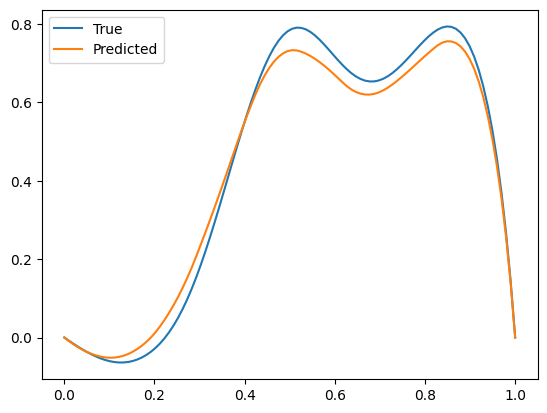

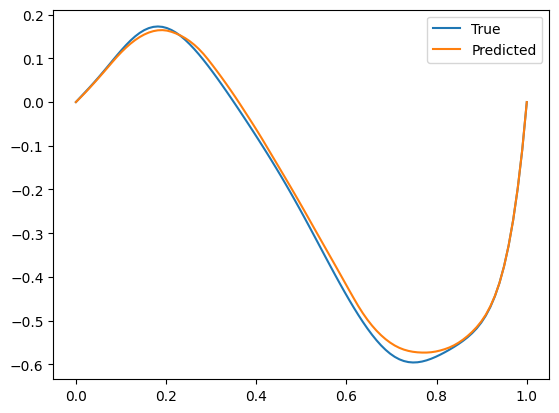

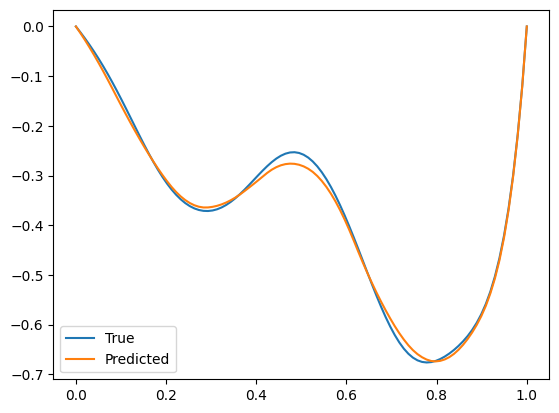

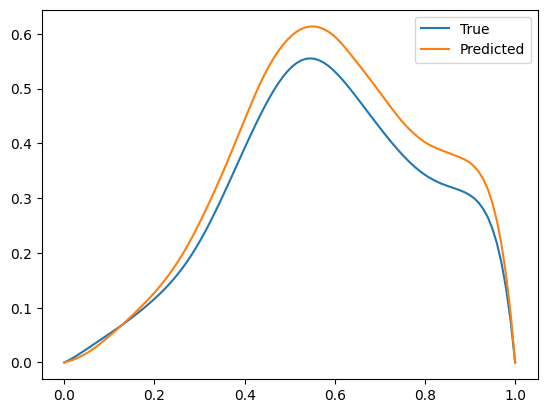

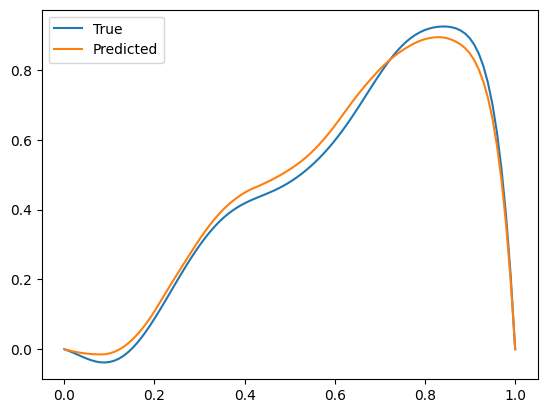

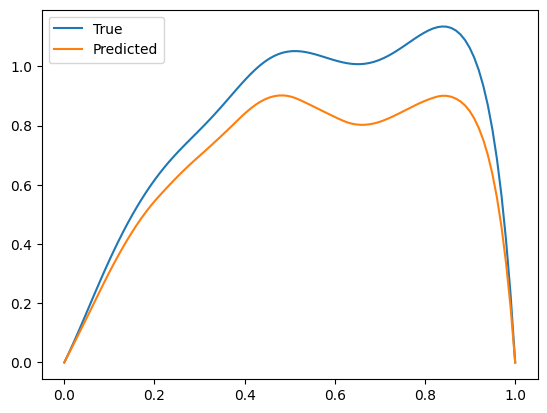

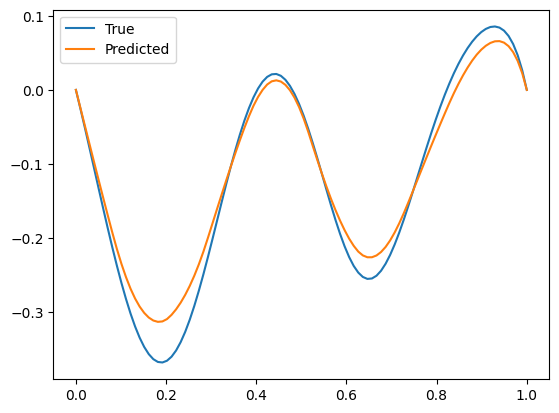

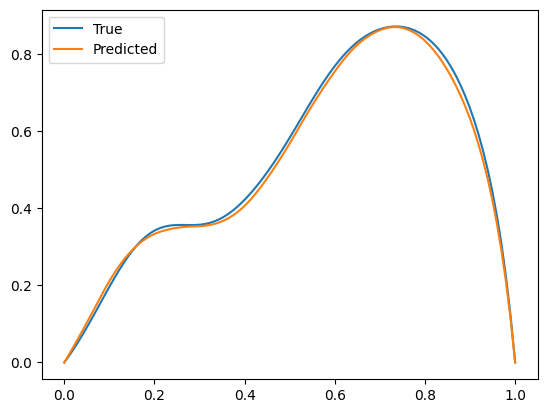

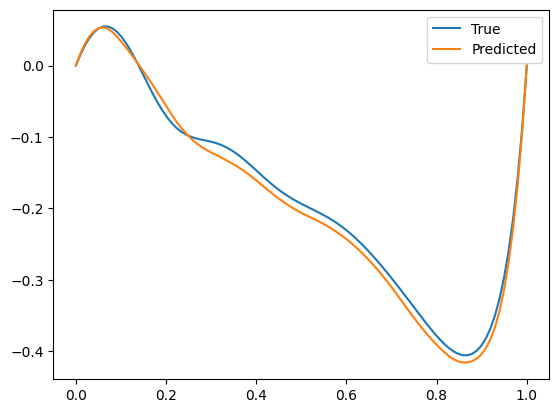

mus.shape (2000, 100)
xs.shape (2000, 100, 1)
sol.shape (2000, 100)


Training progress:   0%|          | 0/10 [00:00<?, ?it/s]2025-08-06 14:29:24,274 - sciml.model.deeponet.deeponet - INFO - Epoch 1/10
2025-08-06 14:29:24,276 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003283
2025-08-06 14:29:24,278 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003248
Training progress:  10%|█         | 1/10 [00:10<01:35, 10.62s/it]2025-08-06 14:29:33,271 - sciml.model.deeponet.deeponet - INFO - Epoch 2/10
2025-08-06 14:29:33,272 - sciml.model.deeponet.deeponet - INFO - Training Loss: 0.003211
2025-08-06 14:29:33,274 - sciml.model.deeponet.deeponet - INFO - Test Loss: 0.003165
Training progress:  20%|██        | 2/10 [00:20<01:23, 10.41s/it]


KeyboardInterrupt: 

In [12]:
for _ in range(10):
    train_history = model.fit()
    plt.figure(figsize=(10,6))
    plt.plot(train_history[0], label='Training Loss')  # we plot training loss
    plt.plot(train_history[1], label='Test Loss')  # we plot test loss
    plt.yscale('log')  # we use log scale for better visualization
    plt.grid(True, which="both", ls="-", alpha=0.2)  # we add grid with transparency
    plt.xlabel('Epochs')  # we add x label
    plt.ylabel('Loss')  # we add y label
    plt.title('Training and Test Loss Over Time')  # we add title
    plt.legend()  # we add legend
    plt.yscale('log')
    plt.xscale('log')
    plt.show()
        
        # then we can test the model
    mu_test, xs_test, sol_test = get_mu_xs_sol(folder_path,0.2,training=False)

    preds = model.predict(mu_test, xs_test)
    for i in range(20):
        plt.plot(xs_test[i,:],sol_test[i,:], label='True')
        plt.plot(xs_test[i,:],preds[i,:], label='Predicted')
        plt.legend()
        plt.show()

In [ ]:
# then we can test the model
mu_test, xs_test, sol_test = get_mu_xs_sol(folder_path,0.2,training=False)

preds = model.predict(mu_test, xs_test)
for i in range(20):
    plt.plot(xs_test[i,:],sol_test[i,:], label='True')
    plt.plot(xs_test[i,:],preds[i,:], label='Predicted')
    plt.legend()
    plt.show()